## Table Of Contents:
* [Introduction](#Introduction)
* [Exploratory Data Analysis](#EDA)
    * [Add Errors to data](#AddError)
* [Feature Engineering](#FE)
* [Common mistake made with left merge and backfill](#Mistake)
* [Solution for mistake ](#Solution)
* [Modelling ](#Model)
    * [24 hr pred. 3 hr lag](#Model24_lag3)
    * [48 hr pred. 3 hr lag](#Model48_lag3)
    * [48 hr pred. 6 hr lag](#Model48_lag6)
    * [24 hr pred. 3 hr shift column lag](#Model24_shift_lag)
    * [48 hr pred. 3 hr shift column lag](#Model48_shift_lag)
* [Observation](#Observation)

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h1 style="text-align:center;font-weight: bold;">Introduction</h1>
<a class="anchor" id="Introduction"></a>

The goal of this project is to build 2 predictive models 1 that a machine component (1, 2, 3, or 4) will fail in the next 24 hours and the second in 48 hours.
As an AVEVA OSISoft PI System Consltant, I have worked with several companies over 25 years. One weakness I have found is some companies do not integrated maintenance data with real time sensor data from the PI System and a tool developed to predict equipment failure.
    
With that in mind, I decided to do my Machine Learning project on Predictive Maintenance using sensor data and data from a Maintenance system.

The dataset was downloaded from https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance
    
Predictive Maintenance relies on historical equipment health data to anticipate future points of failure. This allows for the proactive scheduling of part replacements, just ahead of the actual breakdown. The ultimate goal is to detect anomalies in your operation and possible defects in equipment to prevent failure!
    
</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">PI AF Server</h3>

The failure dataset has timestamps at 06:00. In the real world using the PI System, the maintenance system would be integrated with the advanced computing power of PI AF Server and the exact failure and error times would be in the database, along with other meta data. For training the model, the PI system analysis engine  would be setup to recalculate and backfill using event frames for 24 hours or for whatever periods one would want the model to predict based on historical archived data. The event frames would have the lag feaures calculated (e.g. x hour averages, min, etc). This data would be send to the model for training. Unlike the downloaded kaggle dataset, the PI AF Server would be configured to provide lag data into a more accurate and simple form for the model to process.    
</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Importing Libraries</h3>



</div>





In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, KFold, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from prettytable import PrettyTable
import re
# import plotly.offline as pyo
# pyo.init_notebook_mode()

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Load Data</h3>



</div>





In [2]:
telemetry = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv')
errors = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv')
maint = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv')
failures = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv')
machines = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv')

<a class="anchor" id="EDA"></a>
# Exploratory Data Analysis



### Dataset Description:
There are 5 CSV files consisting of:

- <b>Telemetry Time Series Data (PdM_telemetry.csv):</b> This dataset contains hourly averages of voltage, rotation, pressure, and vibration collected from 100 machines throughout the year 2015. It serves as a record of automated communication processes from various data sources.


- <b>Error (PdM_errors.csv):</b> This dataset documents errors that machines encounter while in operation. It's worth noting that these errors do not lead to machine failures, as the machines continue to operate. The error date and times are rounded to the nearest hour to align with the hourly telemetry data collection rate.


- <b>Maintenance (PdM_maint.csv):</b> This dataset records the replacement of machine components. Such replacements occur in two scenarios: during regularly scheduled maintenance visits (Proactive Maintenance) or as a response to component breakdown, necessitating unscheduled maintenance (Reactive Maintenance). The latter is considered a failure, and corresponding data is also captured in the Failures dataset. Maintenance data encompasses records from both 2014 and 2015 and is time-stamped to the nearest hour in line with the telemetry data collection intervals.
    

- <b>Failures (PdM_failures.csv):</b> Each entry in this dataset signifies the replacement of a machine component due to failure. It's important to note that this dataset is a subset of the Maintenance data, and the timestamps are rounded to the nearest hour to align with the telemetry data collection schedule.


- <b>Metadata of Machines (PdM_Machines.csv):</b> This dataset provides information on the machine models and their ages, offering essential contextual details about the machines in question.

In [3]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [5]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [6]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [7]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


<a class="anchor" id="AddError"></a>
### To make data more realistic, 3 random outlier records for a random machine ID will be created. Based on experience there can be sensor malfunction especially with old sensors.

In [8]:
# Define the datetime, machineID, and columns to append
append_datetime = '2015-07-08 06:45' # Use a dateime that is not on dataset to preserve original data
append_machineID = int(np.random.rand()*100)
columns_to_append = ['volt', 'rotate', 'pressure', 'vibration']

# Generate random data to append
num_rows_to_append = 3  # Number of rows to append
random_data = {
    'datetime': [append_datetime] * num_rows_to_append,
    'machineID': [append_machineID] * num_rows_to_append
}

for column in columns_to_append:
    random_data[column] = np.random.rand(num_rows_to_append) * 100000  # Insert erroneous values

# Create a DataFrame for the random data
random_data_df = pd.DataFrame(random_data)

# Append the random data to the telemetry DataFrame
telemetry = pd.concat([telemetry, random_data_df], ignore_index=True)
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876103.000000,876103.000000,876103.000000,876103.000000,876103.000000
mean,50.500163,170.987533,446.801074,100.974998,40.474458
std,28.866171,128.292900,130.500961,99.550524,57.342824
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,26.000000,160.304963,412.305765,93.498202,36.777304
50%,51.000000,170.607417,447.558712,100.425585,40.237257
75%,76.000000,181.004502,482.177072,107.555278,43.784974
max,100.000000,98371.700643,92936.211367,92434.548822,48961.869026


### Format datatime to Pandas datetime

In [9]:
# Format date & time.
tables = [telemetry, maint, failures, errors]
for table in tables:
    table["datetime"] = pd.to_datetime(table["datetime"], format='mixed') #, format="%Y-%m-%d %H:%M:%S"
    table.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Telemetry Data</h3>
</div>

In [10]:
print(f"Total number of telemetry records: {len(telemetry.index)}" )
print(telemetry.describe())

Total number of telemetry records: 876103
                            datetime      machineID           volt  \
count                         876103  876103.000000  876103.000000   
mean   2015-07-02 18:00:01.636451584      50.500163     170.987533   
min              2015-01-01 06:00:00       1.000000      97.333604   
25%              2015-04-02 12:00:00      26.000000     160.304963   
50%              2015-07-02 18:00:00      51.000000     170.607417   
75%              2015-10-02 00:00:00      76.000000     181.004502   
max              2016-01-01 06:00:00     100.000000   98371.700643   
std                              NaN      28.866171     128.292900   

              rotate       pressure      vibration  
count  876103.000000  876103.000000  876103.000000  
mean      446.801074     100.974998      40.474458  
min       138.432075      51.237106      14.877054  
25%       412.305765      93.498202      36.777304  
50%       447.558712     100.425585      40.237257  
75%      

<b>Based on maximum values there is clearly some errors in data set. Erroneous Data will need to be found. For simplicity use Interquartile Range (IQR) to detect outliers

In [11]:
cols = ['volt', 'rotate', 'pressure', 'vibration']
for col in cols:
    Q1 = telemetry[col].quantile(0.1)
    Q3 = telemetry[col].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = telemetry[(telemetry[col] < lower_bound) | (telemetry[col] > upper_bound)]
    print(f"{col}_outliers : \n{outliers}")

volt_outliers : 
                  datetime  machineID          volt        rotate  \
334620 2015-05-20 16:00:00         21    250.870453    499.702517   
451300 2015-07-08 06:45:00         98  64206.597686  92936.211367   
451301 2015-07-08 06:45:00         98  98371.700643  20039.100308   
451302 2015-07-08 06:45:00         98  21737.496013  60041.287084   
765733 2015-11-16 07:00:00         31    255.124717    535.599871   

            pressure     vibration  
334620    104.247845     49.833998  
451300   3465.127374  48961.869026  
451301   6319.745887  18549.093527  
451302  92434.548822  10979.028303  
765733    120.334615     41.050507  
rotate_outliers : 
                  datetime  machineID          volt        rotate  \
30584  2015-01-13 23:00:00         85    174.085237    176.922119   
36980  2015-01-16 15:00:00         81    164.297095    167.099105   
175223 2015-03-15 06:00:00         24    152.406161    177.433821   
189664 2015-03-21 06:00:00         65    172.335787

<b>After manual inspection the identified outliers or erroneous data points were found on datetime 2015-07-08 06:45:00. Based on SCADA Automation team's domain knowledge, it's determined to be instrumentation errors and should be removed.

In [12]:
telemetry = telemetry[telemetry['datetime'] != '2015-07-08 06:45']
telemetry.describe()

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


This process is often iterative. After data cleaning, you may need to re-analyze the data, and if necessary, repeat the process to ensure data quality.
Data looks OK now.

# Plot all Sensor data for a Machine for the dataset.

In [13]:
plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2016-02-01')), ['datetime', 'volt','rotate', 'pressure','vibration']]

In [14]:
# Create the figure
''' Available templates : ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white',
                           'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']'''

fig = go.Figure()

# Add the traces for 'volt', 'rotate', 'pressure', and 'vibration' using different y-axes
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['volt'].values, name='Voltage', yaxis='y'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['rotate'].values, name='Rotation', yaxis='y2'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['pressure'].values, name='Pressure', yaxis='y3'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['vibration'].values, name='Vibration', yaxis='y4'))

# Update the layout to show four y-axes
fig.update_layout(
    title='Machine 1 Sensor Data over Time',
    xaxis_title='Date',
    template='seaborn',
    yaxis=dict(title='Voltage', side='left', position=0),
    yaxis2=dict(title='Rotation', overlaying='y', side='left', position=0.02),
    yaxis3=dict(title='Pressure', overlaying='y', side='right', position=0.97),
    yaxis4=dict(title='Vibration', overlaying='y', side='right', position=1),
    legend=dict(orientation="h", y=-0.1, x=0.25)  # Adjust legend position 
)
# Show the plot
fig.show()

Click on legend to hide/unhide trend line
Highlight and select data range
Pan feature is available

 <div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Errors Data</h3>



</div>





In [15]:
errors['errorID'] = errors['errorID'].astype('object')

print(f"Total number of error records: {len(errors.index)}")
errors.head()

Total number of error records: 3919


,datetime,machineID,errorID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4


In [16]:
fig = px.bar(x=errors['errorID'].values,
             title='Count of Errors', template='none', color=errors['errorID'].values)
fig.update_layout(xaxis_title='Error Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})

# Show the plot
fig.show()

<Axes: title={'center': 'Number of errors for MachineID'}, ylabel='machineID'>

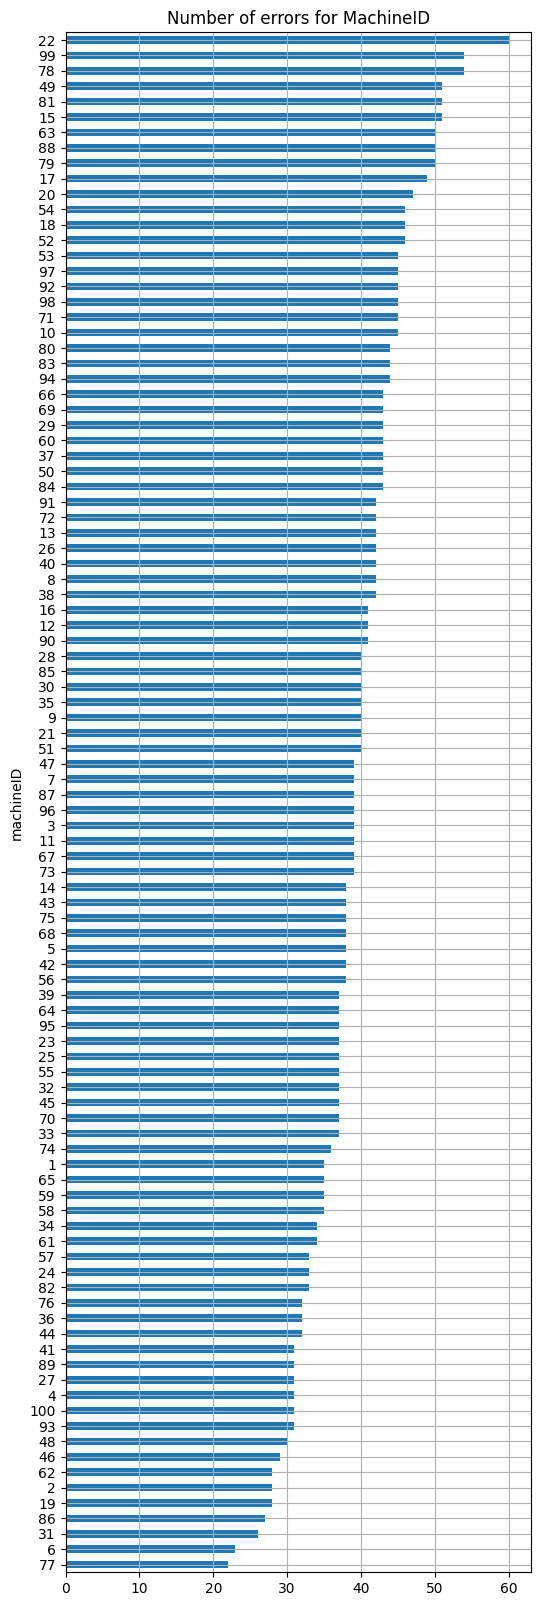

In [17]:
errors["machineID"].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='barh', figsize=(6, 20), grid=True,
                title="Number of errors for MachineID")

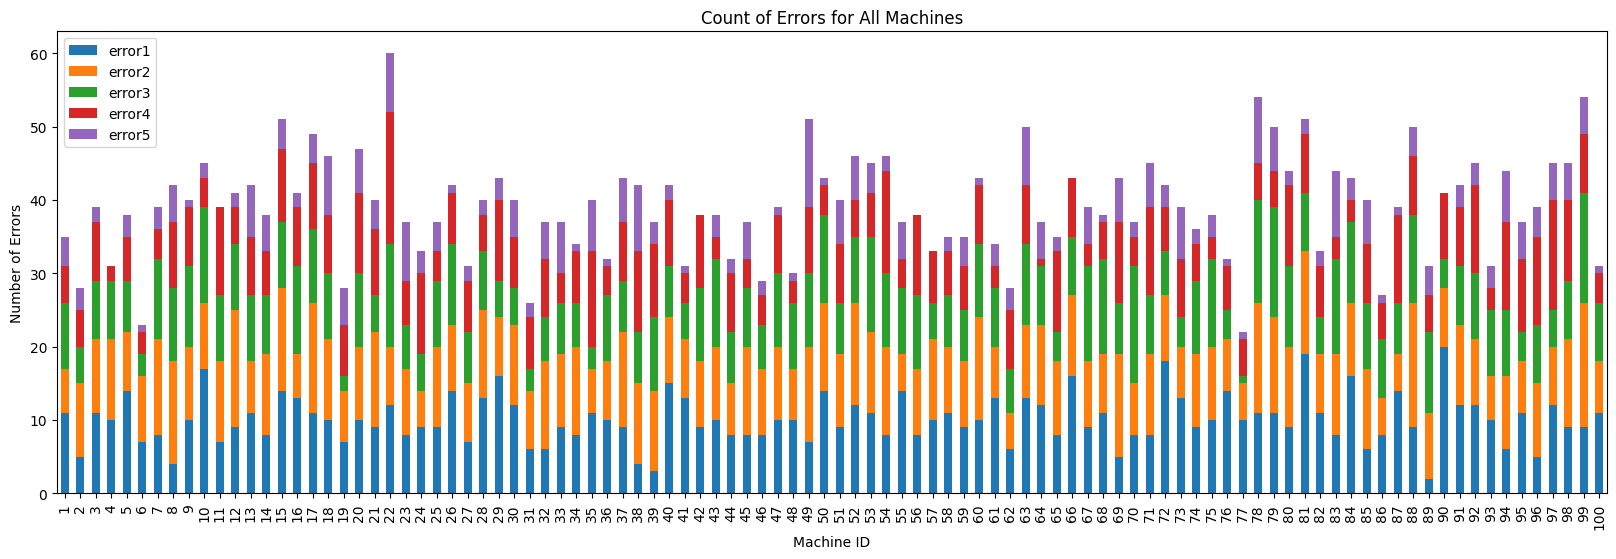

In [18]:
error_cnt = errors.groupby(["machineID", "errorID"]).size().reset_index()
error_cnt.columns = ["machineID", "errorID", "error_val"]
error_cnt_pivot = pd.pivot(error_cnt, index="machineID", columns="errorID", values="error_val").rename_axis(None, axis=1)
error_cnt_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Errors for All Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Errors");

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Maintainence Data</h3>
</div>





In [19]:
maint['comp'] = maint['comp'].astype('object')

print(f"Total number of maintenance records: {len(maint.index)}")
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [20]:
fig = px.bar(x=maint['comp'].values,
             title='Count of Comp', template='none', color=maint['comp'].values) #
fig.update_layout(xaxis_title='Comp Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})
fig.show()

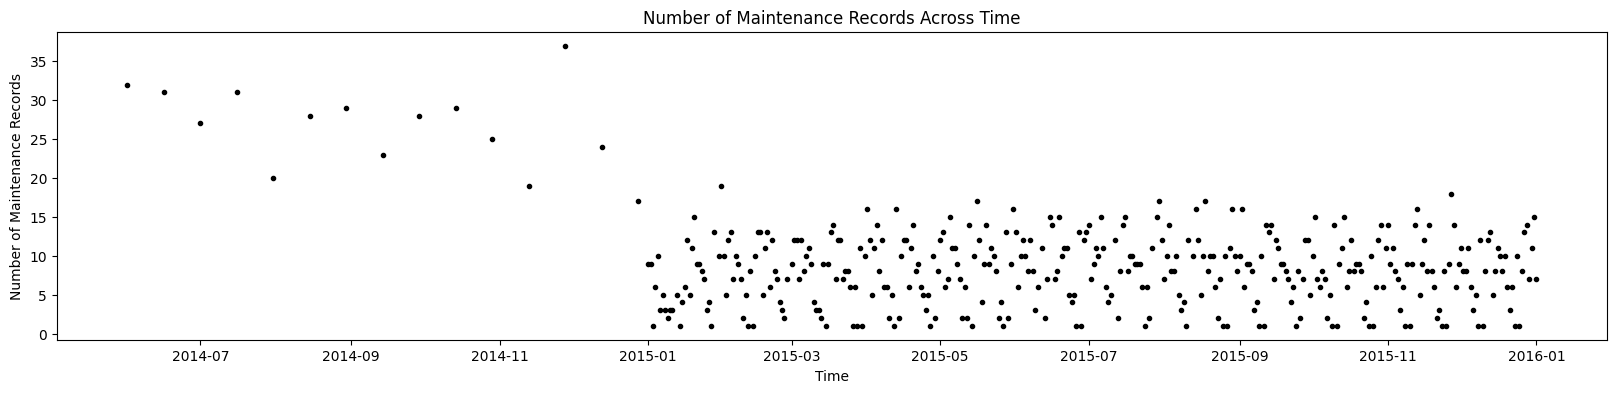

In [21]:
maint.datetime.dt.date.value_counts().plot(
    style="k.",
    figsize=(20, 4),
    title="Number of Maintenance Records Across Time")
plt.ylabel("Number of Maintenance Records")
plt.xlabel("Time")
plt.show()

This indicates that data is sparse in 2014 when compared to the number of maintenance records in 2015.

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Machine Data</h3>



</div>





In [22]:
machines['model'] = machines['model'].astype('object')

print(f"Total number of machines: {len(machines.index)}")
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


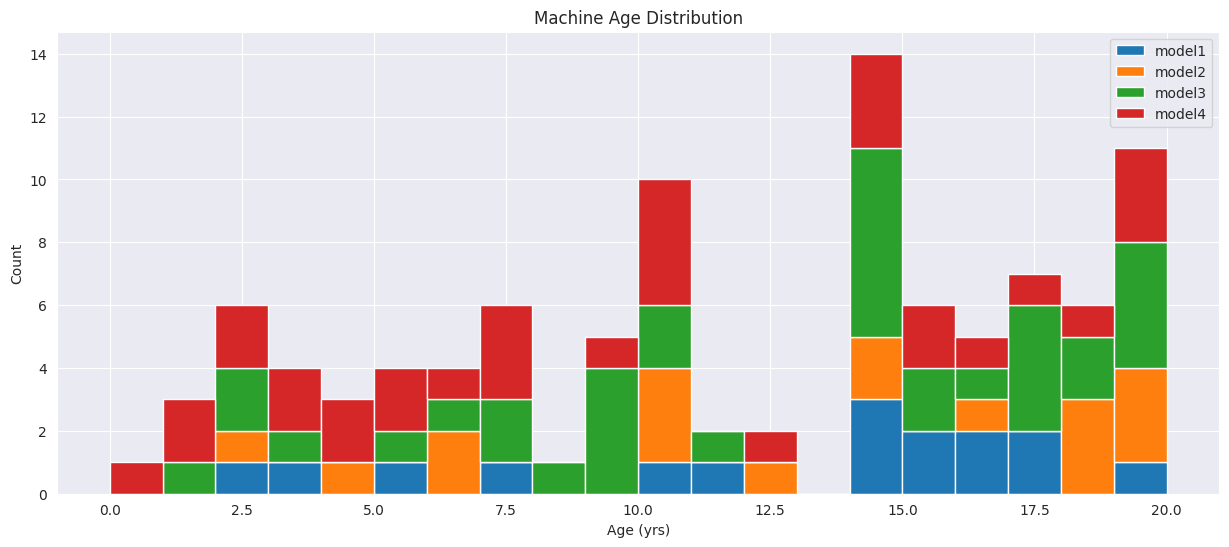

In [23]:

sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.title('Machine Age Distribution')
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">EDA on Failure Data</h2>



</div>





In [24]:
failures['failure'] = failures['failure'].astype('object')

print(f"Total number of failures: {len(failures.index)}")
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


In [25]:
fig = px.bar(x=failures['failure'].values, title='Count of Failures', template='none', color=failures['failure'].values)
fig.update_layout(xaxis_title='Failure Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})
fig.show()

The Failures dataset records a total of 761 failure instances. The majority of these failures are attributed to component-2. Need to investigate the underlying reasons for these component-2 failures to reduce the overall incidence of equipment failures in the future.

<a class="anchor" id="FE"></a>
#                     Feature Engineering

<div style="color:white;
           display:fill;
           border-radius:15px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold">Predictive Maintenance and Time Series Data</h3>

Base on research from an article from **Jason Brownlee PhD**. Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

We must invent input and output variables too and frame the supervised learning problem from scratch.
In effect, the best default strategy is to use all the knowledge available to create many good datasets from your time series dataset and use model performance (and other project requirements) to help determine what good features and good views of your problem happen to be.  

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window.
</div>


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Lag Feature Engineering</h3>



</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create Lag Features from Telemetry Data on a window of 24 hours</h4>



</div>





In [26]:
# ## Note on append pd.pivot_table ##
# Within the loop, a pandas pivot_table operation is performed
# This operation is used to create a pivot table, which essentially reshapes the data.
# Index='datetime': The 'datetime' column is specified as the index for the pivot table.
# columns='machineID': The 'machineID' column is specified as the column headers for the pivot table.
# values=col: The 'col' variable, which represents the feature of interest, is used as the values
# to populate the pivot table.
# .resample('3H', closed='left', label='right'): After creating the pivot table, a time series resampling operation
# is applied. The .resample method is used to resample the data with a time interval of 3 hours.
# The parameters used are: closed='left': This specifies that the resampling should be based on the left-closed intervals
# (e.g., if the original data had timestamps at 1:00, 4:00, 7:00, etc., the 3-hour intervals would be
# [1:00-4:00], [4:00-7:00], etc.).
# label='right': This specifies that the labels for the resampled intervals should be placed on the right side of
# each interval.
# .first(): The .first() method is used to select the first value within each resampled interval. This is often
# used to downsample data when multiple values fall within the same interval.
# .unstack(): The .unstack() method is applied to reshape the result, essentially reverting it back to a
# tabular format where 'machineID' becomes a column instead of multi-level columns. For window = 24
# .rolling(window=24, center=False): A rolling window calculation is performed on the unstacked data.
# This calculates a rolling sum within a window of 24 data points. The center=False parameter specifies that
# the rolling window should not be centered around each data point but should start from the current point
# and include the next 23 data points.
# .sum(): The rolling sum is calculated for each rolling window.

In [27]:
def resample_feat_rule(df, features, rule, aggrs):
    # Calculate "resample 'min', 'max', 'mean', or 'std' values" over the last 'input rule' hour lag window
    # for telemetry features.
    temp = []
    columns = []
    for aggr in aggrs: # loop iterates through the aggregate list
        for col in features: # loop iterates through the columns in feature list
            if aggr == 'min':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').min().unstack())
            elif aggr == 'max':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').max().unstack())
            elif aggr == 'mean':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').mean().unstack())
            elif aggr == 'std':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').std().unstack())
            else:
                raise ValueError("Invalid method name. Use 'min', 'max', 'mean', or 'standard deviation'.")
        df_temp = pd.concat(temp, axis=1)
        columns = columns + [i + '_' + aggr + '_' + rule.lower() for i in features]
    df_temp.columns = columns
    df_temp.reset_index(inplace=True)
    return df_temp

In [28]:
def roll_resample_feat_rule(df, features, window, rule, aggrs):
    # Calculate "rolling resample 'min', 'max', 'mean', 'std' or sum values" over the last 'input rule' hour lag window
    # for telemetry features.
    temp = []
    columns = []
    for aggr in aggrs: # loop iterates through the aggregate list
        for col in features: # loop iterates through the columns in feature list
            if aggr == 'min':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).min().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'max':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).max().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'mean':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).mean().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'std':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).std().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'sum':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).sum().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            else:
                raise ValueError("Invalid method name. Use 'min', 'max', 'mean', or 'standard deviation' , or 'sum'.")
        df_temp = pd.concat(temp, axis=1)
        columns = columns + [i + '_' + aggr + '_' + str(window) for i in features]
    df_temp.columns = columns
    df_temp.reset_index(inplace=True)
    # Remove nans for the first set of calculations will not have values for the 24H window
    df_temp.dropna(inplace=True)
    return df_temp

In [29]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
window = 24
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 3 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 24 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat.describe()


,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,pressure_min_24,vibration_min_24,volt_max_24,rotate_max_24,pressure_max_24,vibration_max_24,volt_std_24,rotate_std_24,pressure_std_24,vibration_std_24
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,158.071254,404.140202,92.378383,36.147281,...,81.131811,30.545026,200.180628,544.978282,120.628765,50.224220,14.918849,49.947916,10.046687,5.002065
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,174.045035,354.689433,101.486195,41.786127,6.380619,18.385248,4.145308,2.144863
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,150.363984,379.505260,86.862285,33.457488,...,77.553554,28.792671,194.108725,527.494489,116.041542,48.051757,13.358663,44.668824,8.924317,4.460347
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,158.162633,406.887414,92.115722,36.088251,...,81.202640,30.587247,199.106415,544.249465,119.355064,49.704299,14.853948,49.613807,9.921407,4.958594
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,165.835015,432.057742,97.273981,38.666539,...,84.416451,32.216707,204.944435,562.208836,123.330351,51.697676,16.394764,54.821318,10.980498,5.484480
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,140.668648,54.817952,255.124717,695.020984,185.951998,76.791072,27.664538,103.819404,28.654103,12.325783
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,11.871003,40.811111,8.775150,4.206936,...,6.288144,2.990002,8.754514,28.736918,7.247956,3.305991,2.260726,7.682126,1.713726,0.799820


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create dummies DF from Error Data and sum errors in a 24 hour window</h4>
</div>

In [30]:
# The error IDs are categorical values so count the number of errors of each type in a lagging window
# Create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# Group by 'machineID' and 'datetime' and calculate the sum of errors and then resets the error_count index
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


In [31]:
# Combine errors for a given machine in a given telemetry hour
# telemetry has data for every hour
error_count = telemetry[['datetime', 'machineID']].merge(
    error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()


,datetime,machineID,error1,error2,error3,error4,error5
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-07-02 18:00:00,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015-10-02 00:00:00,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016-01-01 06:00:00,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create DF for rolling sum of errors in a 24 hour window for each 3 hour datetime</h4>
</div>

In [32]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 24
error_count24 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)

In [33]:
error_count24.describe()


,machineID,datetime,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24
count,291400.00000,291400,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,2015-07-03 07:30:00,0.027649,0.027069,0.022907,0.019904,0.009753
min,1.00000,2015-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.166273,0.164429,0.151453,0.140820,0.098797


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Machine Features</h2>



</div>

In [34]:
# create component dummies
comp_dum = pd.get_dummies(maint.set_index('datetime')).reset_index()
# rename columns
comp_dum.columns = ['datetime', 'machineID',
                    'comp1', 'comp2', 'comp3', 'comp4']

# In cases where more than 1 component  for a machine is repaired in the same hour Combine repairs
# This will prevent duplicates when doing outer join
comp_dum = comp_dum.groupby(['machineID', 'datetime']).sum().reset_index()

# outer join merge of component dummies to telemetry data datetimes
# and machine Id filling nan with zeros. sort by machine Id and datetime
comp_dum = telemetry[['datetime', 'machineID']].merge(comp_dum,
                                                      on=['datetime',
                                                          'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
comp_dum.head()

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
876101,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
876102,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
876103,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Calculate time component in use before changed. Time is in hours</h4>
</div>

In [35]:
# loop through each component column dummies and replace 0 with nan
# component which is equal to 1 with the datetime of maintenace date
# forward fill nan with the last datetime observation forward to next datetime.
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    comp_dum.loc[comp_dum[comp] == 0, comp] = None
    comp_dum.loc[comp_dum[comp] == 1,
                 comp] = comp_dum.loc[comp_dum[comp] == 1, 'datetime']
    comp_dum[comp] = comp_dum[comp].fillna(method='ffill')
# filter data starting at 2015-01-01, which ignore previous years data with nan
# as we need to do pandas date diference to calculate component in use time
# and 2014 data is sparse
comp_dum = comp_dum.loc[comp_dum['datetime'] > pd.to_datetime('2015-01-01')]
# Calculate time component in use before changed. Time is in hours
for comp in components:
    comp_dum[comp] = (comp_dum["datetime"] - pd.to_datetime(comp_dum[comp])).dt.total_seconds() / 3600
comp_dum.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,1284.604452,1236.979340,1265.423080,1292.020591
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,319.000000,291.000000,315.000000,312.000000
50%,2015-07-02 18:00:00,50.500000,787.000000,712.000000,775.000000,780.000000
75%,2015-10-02 00:00:00,75.250000,1649.000000,1597.000000,1616.000000,1691.000000
max,2016-01-01 06:00:00,100.000000,11807.000000,8375.000000,8903.000000,9479.000000
std,NaN,28.866087,1499.800290,1422.462106,1412.954744,1432.991482


In [36]:
comp_dum.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,456.0,5136.0,3696.0,4056.0
100,2015-01-01 07:00:00,1,457.0,5137.0,3697.0,4057.0
200,2015-01-01 08:00:00,1,458.0,5138.0,3698.0,4058.0
300,2015-01-01 09:00:00,1,459.0,5139.0,3699.0,4059.0
400,2015-01-01 10:00:00,1,460.0,5140.0,3700.0,4060.0


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Merge all the feature data sets</h4>
</div>

In [37]:
mach_feature = telemetry_lagfeat.merge(error_count24, on=['datetime', 'machineID'], how='left')
mach_feature = mach_feature.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature = mach_feature.merge(machines, on=['machineID'], how='left')
mach_feature.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,158.071254,404.140202,92.378383,36.147281,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,150.363984,379.505260,86.862285,33.457488,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,158.162633,406.887414,92.115722,36.088251,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,165.835015,432.057742,97.273981,38.666539,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,11.871003,40.811111,8.775150,4.206936,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>



</div>

In [38]:
# Merge df using 'datetime'and 'machineID' which will create nan for non existent failure row
labeled_features = mach_feature.merge(failures, on=['datetime', 'machineID'], how='left')
# All records within a 24 hour window before a failure of component 1 have `failure=comp1`,
# and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have `failure=none`
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill 7 rows backward up to (3h * 8) 24h
labeled_features['failure'] = labeled_features['failure'].astype('str')
labeled_features.replace({'nan': "none"}, inplace= True)
labeled_features.dropna(inplace= True)

<a class="anchor" id="Mistake"></a>
**Based on my over 31 years of working with databases and SQL, I noticed that all the solutions I have seen that use the left merge on the lag machine features have made a fundamental error. All assumed that there are no duplicates in the failures data for 'datetime' and 'machineID'. The backfill will only work for the first component failure and only have one value for the other duplicates!  
Lets check for duplicates in failures DF.**

In [39]:
# Selecting duplicate rows based on datetime and machineID columns
# 82 duplicate record, therefore 41 records in error
failures_duplicate_rows = failures[failures.duplicated(subset=['datetime', 'machineID'], keep=False)]
print(failures_duplicate_rows.count)
print(failures_duplicate_rows.head(50))

<bound method DataFrame.count of                datetime  machineID failure
0   2015-01-02 03:00:00         16   comp1
1   2015-01-02 03:00:00         16   comp3
31  2015-01-07 06:00:00         12   comp1
32  2015-01-07 06:00:00         12   comp2
57  2015-01-19 06:00:00         52   comp2
..                  ...        ...     ...
720 2015-12-13 06:00:00         38   comp4
739 2015-12-22 06:00:00         13   comp1
740 2015-12-22 06:00:00         13   comp2
750 2015-12-27 06:00:00         83   comp1
751 2015-12-27 06:00:00         83   comp2

[84 rows x 3 columns]>
               datetime  machineID failure
0   2015-01-02 03:00:00         16   comp1
1   2015-01-02 03:00:00         16   comp3
31  2015-01-07 06:00:00         12   comp1
32  2015-01-07 06:00:00         12   comp2
57  2015-01-19 06:00:00         52   comp2
58  2015-01-19 06:00:00         52   comp4
61  2015-01-20 06:00:00         15   comp2
62  2015-01-20 06:00:00         15   comp4
72  2015-01-24 06:00:00          7   com

Lets look at duplicate for machine 2 at 2015-03-19 06:00:00 as an example. We should have gotten 8 records for both comp1 and comp2. Comp2 only has 1 record.

In [40]:
#We should have gotten 8 records for the duplicate record comp2 instead of 1
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 2) &     # Filtering for 'machineID' column with value y
    (labeled_features['datetime'] > pd.to_datetime('2015-03-18 06:00:00')) &
    (labeled_features['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3514,2,2015-03-18 09:00:00,175.471523,382.521159,93.885594,38.319541,168.448450,310.368039,89.573491,34.848273,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comp1
3515,2,2015-03-18 12:00:00,205.271773,340.915117,101.364846,43.819837,199.889985,326.882539,99.880972,42.522563,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comp1
3516,2,2015-03-18 15:00:00,194.075044,354.935806,98.938486,33.031944,191.809899,285.292465,83.219087,31.114643,...,1.0,0.0,0.0,6609.0,5169.0,705.0,345.0,model4,7,comp1
3517,2,2015-03-18 18:00:00,197.913116,353.425520,85.665069,40.880938,188.313423,284.233536,77.487338,36.950184,...,1.0,0.0,0.0,6612.0,5172.0,708.0,348.0,model4,7,comp1
3518,2,2015-03-18 21:00:00,191.020676,415.868484,95.586852,41.281117,163.239141,305.955952,86.744758,38.347916,...,1.0,0.0,0.0,6615.0,5175.0,711.0,351.0,model4,7,comp1
3519,2,2015-03-19 00:00:00,191.476875,374.713495,101.884021,41.603551,183.588731,314.237986,88.837158,34.794333,...,1.0,0.0,0.0,6618.0,5178.0,714.0,354.0,model4,7,comp1
3520,2,2015-03-19 03:00:00,193.937828,364.435535,102.726284,34.400963,191.720614,257.891638,91.342034,30.857904,...,1.0,0.0,0.0,6621.0,5181.0,717.0,357.0,model4,7,comp1
3521,2,2015-03-19 06:00:00,177.978058,377.662333,109.773125,40.125778,163.674462,360.224008,100.753128,33.515403,...,1.0,0.0,0.0,0.0,0.0,720.0,360.0,model4,7,comp1
3522,2,2015-03-19 06:00:00,177.978058,377.662333,109.773125,40.125778,163.674462,360.224008,100.753128,33.515403,...,1.0,0.0,0.0,0.0,0.0,720.0,360.0,model4,7,comp2


<a class="anchor" id="Solution"></a>
## **Solution for duplicate failure records.**

In [41]:
# Create 4 empty dataframes as it may be possible for up to 4 components failing at the
# same time for a particular Machine. Each DF will store the set of duplicate records
# eg. dup_dfs[0] - first , dup_dfs[1] - second duplicate set , dup_dfs[2] - third duplicate set
# dup_dfs[3] - fourth duplicate set

column_names = ['datetime', 'machineID', 'failure']
dup_dfs = [pd.DataFrame(columns=column_names) for _ in range(4)]

# Finds the set of duplicates and place them in dataframe based on there row index .
for index, row in failures_duplicate_rows.iterrows():
    # .sum(), it counts the number of True values in that Boolean Series.
    #  The > 1 condition checks whether the count of occurrences where the 'datetime' value is equal to row['datetime']
    #  and 'machineID' == row['machineID'] is greater than 1. If the count is greater than 1,
    #  it means there are at least two rows with the same 'datetime' value in the DataFrame.
    if ((failures['datetime'] == row['datetime']) & (failures['machineID'] == row['machineID'])).sum() > 1:
        indexes = failures[
            (failures['datetime'] == row['datetime']) & (failures['machineID'] == row['machineID'])].index

        for i, idx in enumerate(indexes):
            if idx not in dup_dfs[i].index:
                # converts the selected row into a DataFrame and transposes it to match the column structure.
                # ignore_index=False ensures the resulting DataFrame use the failure index.
                dup_dfs[i] = pd.concat([dup_dfs[i], failures.loc[idx, column_names].to_frame().T], ignore_index=False)
for df in dup_dfs:
    print(df)

               datetime machineID failure
0   2015-01-02 03:00:00        16   comp1
31  2015-01-07 06:00:00        12   comp1
57  2015-01-19 06:00:00        52   comp2
61  2015-01-20 06:00:00        15   comp2
72  2015-01-24 06:00:00         7   comp2
75  2015-01-24 06:00:00        97   comp3
78  2015-01-26 06:00:00        71   comp3
81  2015-01-28 06:00:00        63   comp1
91  2015-01-31 06:00:00        33   comp1
178 2015-03-19 06:00:00         2   comp1
190 2015-03-23 06:00:00        22   comp2
203 2015-04-01 06:00:00        17   comp2
237 2015-04-11 06:00:00        13   comp3
255 2015-04-20 06:00:00        11   comp2
258 2015-04-20 06:00:00        92   comp1
270 2015-04-30 06:00:00        98   comp2
310 2015-05-19 06:00:00        66   comp1
318 2015-05-22 06:00:00        22   comp1
339 2015-06-03 06:00:00        25   comp1
379 2015-06-24 06:00:00        32   comp2
389 2015-06-29 06:00:00        98   comp1
394 2015-07-01 06:00:00        16   comp2
424 2015-07-15 06:00:00        83 

In [42]:
# Get the indices of duplicate rows and drop duplicate records

failures_without_duplicates = failures
for i in range(1,4):
    if not dup_dfs[i].empty:
        failures_without_duplicates = failures_without_duplicates.drop(dup_dfs[i].index)

# Check the DataFrames
print("Failure records \n",failures.describe())
print("Failure without duplicates \n",failures_without_duplicates.describe())

Failure records 
                             datetime   machineID
count                            761  761.000000
mean   2015-06-24 12:12:17.976346880   51.911958
min              2015-01-02 03:00:00    1.000000
25%              2015-03-23 06:00:00   24.000000
50%              2015-06-24 06:00:00   51.000000
75%              2015-09-23 06:00:00   79.000000
max              2015-12-31 06:00:00  100.000000
std                              NaN   29.515542
Failure without duplicates 
                             datetime   machineID
count                            719  719.000000
mean   2015-06-24 11:32:12.684283648   52.349096
min              2015-01-02 03:00:00    1.000000
25%              2015-03-23 06:00:00   24.000000
50%              2015-06-23 06:00:00   52.000000
75%              2015-09-23 06:00:00   79.000000
max              2015-12-31 06:00:00  100.000000
std                              NaN   29.362194


This model will uses 4 machine learning algorithms to find the best one. The models are XGBoost, HistGradientBoostingClassifier, RandomForestClassifier and Linear Support Vector Classifier.

The order of records in the dataset can influence the training process of machine learning algorithms, including XGBoost and HistGradientBoostingClassifier. XGBoost and HistGradientBoostingClassifier are ensemble learning algorithm that builds a series of decision trees to make predictions.

In creating this function, consideration regarding the order of records was important as XGBoost and HistGradientBoostingClassifier are gradient boosting algorithms, which builds trees sequentially. Each new tree corrects the errors of the previous ones. The order of records determines the order in which the algorithm learns from the data.

RandomForestClassifier and Linear Support Vector Classifier are generally less sensitive to the order of records. Random Forest inherently introduces randomness during training by using bootstrapped samples and random feature selection, which helps reduce sensitivity to the order of records. Linear Support Vector Classifier models assume a linear relationship between features and the target variable, so their performance is more dependent on the linear separability of classes than the order of records.

In this Predictive Maintenance Model case we are using time-series data, the order is crucial as we are predicting future values based on past ones, maintaining the temporal order is important.

This function also duplicated 10 days data before the failure that the ML model (esp gradient boosting)  can learn the none failure records before the failure ones.

In [43]:
def create_labels(mach_feature,failures_without_duplicates,
                  dup_dfs,fill_hrs, laghrs):
    # Merge failures_without_duplicates using 'datetime'and 'machineID' which will create
    # nan for non existent failure row
    labeled_features = mach_feature.merge(failures_without_duplicates,
                                          on=['datetime', 'machineID'], how='left')
    # All records within a 'fill_hrs' hour window before a failure of component 1 have
    # `failure=comp1`, and so on for components 2, 3, and 4; all records not within
    # 'fill_hrs' hours of a component failure have `failure=none`
    limit = int(fill_hrs / laghrs) - 1
    # fill rows backward up to (laghrs * fill_hrs)
    labeled_features = labeled_features.fillna(method='bfill', limit=limit)
    # Merge duplicate files with mach_feature, backfill failure comp,
    # Remove unwanted machineID records, backfill "none" for 10 days and drop nan
    for i in range(1,4):
        if not dup_dfs[i].empty:
            df_temp = dup_dfs[i]
            df = mach_feature.merge(dup_dfs[i], on=['datetime', 'machineID'], how='left')
            df = df.fillna(method='bfill', limit=limit)
            # Get unique machineIDs from dup_dfs[i]
            unique_machineIDs = dup_dfs[i]['machineID'].unique()
            # Filter df to keep only records with machineID in df
            df = df[df['machineID'].isin(unique_machineIDs)]
            # Loop through DataFrame df and backfill failure column with "none" corresponding rows
            # in DataFrame dup_dfs[i] where df datetime <= 10 days dup_dfs[i] datetime
            # and corresponding machineID and value contain Nan
            ndays = 10
            for index, row in dup_dfs[i].iterrows():
                df.loc[(df['datetime'] >= row['datetime'] - pd.to_timedelta(ndays, unit='D')) &
                  (df['datetime'] <= row['datetime']) &
                  (df['machineID'] == row['machineID']), 'failure'] = \
                df.loc[(df['datetime'] >= row['datetime'] - pd.to_timedelta(ndays, unit='D')) &
                      (df['datetime'] <= row['datetime']) &
                      (df['machineID'] == row['machineID']), 'failure'].fillna("none")
            df.dropna(inplace= True)
            labeled_features = pd.concat([labeled_features,df],ignore_index=True)
    labeled_features['failure'] = labeled_features['failure'].astype('str')
    labeled_features.replace({'nan': "none"}, inplace= True)
    # Create a new column named 'row_number' containing row numbers starting from 0.
    # Then use this column for sorting:
    labeled_features['row_number'] = range(len(labeled_features))
    labeled_features.sort_values(by=["machineID", "row_number", "failure", "datetime"], inplace=True, ignore_index=True)
    # Drop the 'row_number' column as it is not needed anymore
    labeled_features.drop('row_number', axis=1, inplace=True)
    return labeled_features


In [44]:
labeled_features = create_labels(mach_feature,failures_without_duplicates,
                  dup_dfs,fill_hrs=24, laghrs=3)

In [45]:
labeled_features.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,294581.000000,294581,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,...,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000
mean,50.444598,2015-07-03 04:09:35.132815616,170.790622,446.508109,100.870559,40.396893,158.089656,404.029379,92.393756,36.158985,...,0.028016,0.027806,0.023637,0.020181,0.010381,1289.377129,1237.241709,1261.202847,1292.361354,11.356018
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 03:00:00,164.455629,427.471388,96.241138,38.149146,150.370254,379.382161,86.864308,33.460554,...,0.000000,0.000000,0.000000,0.000000,0.000000,321.000000,291.000000,315.000000,312.000000,7.000000
50%,50.000000,2015-07-03 06:00:00,170.442878,448.342281,100.236357,40.151064,158.175390,406.835226,92.120293,36.092588,...,0.000000,0.000000,0.000000,0.000000,0.000000,792.000000,711.000000,774.000000,783.000000,12.000000
75%,75.000000,2015-10-02 03:00:00,176.623526,468.417321,104.409676,42.236950,165.851715,432.008960,97.285093,38.675857,...,0.000000,0.000000,0.000000,0.000000,0.000000,1650.000000,1602.000000,1611.000000,1689.000000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.896801,NaN,9.518730,33.252937,7.441922,3.495679,11.888258,40.926024,8.804431,4.221435,...,0.167429,0.166610,0.153759,0.141822,0.101858,1507.627488,1420.892446,1407.657587,1432.382356,5.820403


In [46]:
# Test with Duplicate for machine Id = 2 : 32 records instead of 9, 8 for comp1 and comp2, 8 'none' records before each
# comp records also shown
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 2) &     # Filtering for 'machineID' column with value y
    (labeled_features['datetime'] > pd.to_datetime('2015-03-17 06:00:00')) &
    (labeled_features['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3506,2,2015-03-17 09:00:00,191.877454,371.051731,96.072228,41.693572,175.643659,321.623599,84.842255,36.297268,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,none
3507,2,2015-03-17 12:00:00,182.461251,373.972592,104.486993,43.968925,161.932600,327.363472,97.749591,40.654986,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,none
3508,2,2015-03-17 15:00:00,205.910271,403.503659,99.287823,44.496410,189.319913,381.315999,85.973884,36.071818,...,0.0,0.0,0.0,6585.0,5145.0,681.0,321.0,model4,7,none
3509,2,2015-03-17 18:00:00,187.751919,324.751326,98.862119,37.582892,183.855583,291.094371,89.866327,31.769829,...,0.0,0.0,0.0,6588.0,5148.0,684.0,324.0,model4,7,none
3510,2,2015-03-17 21:00:00,188.363340,361.730218,98.875875,43.860186,172.908211,276.151681,81.848081,39.607366,...,0.0,0.0,0.0,6591.0,5151.0,687.0,327.0,model4,7,none
3511,2,2015-03-18 00:00:00,186.215722,382.312640,97.758428,41.153953,168.768124,353.252636,93.232983,35.790437,...,0.0,0.0,0.0,6594.0,5154.0,690.0,330.0,model4,7,none
3512,2,2015-03-18 03:00:00,180.622299,385.595525,99.502679,42.897261,175.457844,365.631041,96.863519,39.589868,...,0.0,0.0,0.0,6597.0,5157.0,693.0,333.0,model4,7,none
3513,2,2015-03-18 06:00:00,198.964800,354.151424,96.583189,42.471818,174.788266,335.065946,87.934106,40.728454,...,0.0,0.0,0.0,6600.0,5160.0,696.0,336.0,model4,7,none
3514,2,2015-03-18 09:00:00,175.471523,382.521159,93.885594,38.319541,168.448450,310.368039,89.573491,34.848273,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comp1
3515,2,2015-03-18 12:00:00,205.271773,340.915117,101.364846,43.819837,199.889985,326.882539,99.880972,42.522563,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comp1


In [47]:
# Test with Duplicate for machine Id = 17 : 16 records instead of 9, 8 for comp3 and comp4, 8 'none' records before each
# comp records also shown
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 17) &     # Filtering for 'machineID' column with value Y
    (labeled_features['datetime'] > pd.to_datetime('2015-10-26 06:00:00')) &   # Lower bound
    (labeled_features['datetime'] <= pd.to_datetime('2015-10-28 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
49755,17,2015-10-26 09:00:00,168.194304,501.167857,129.861505,50.153154,159.385809,464.546579,124.960200,45.539960,...,0.0,0.0,0.0,2115.0,1035.0,3195.0,1395.0,model1,14,none
49756,17,2015-10-26 12:00:00,180.611652,411.941648,127.245140,52.224550,165.321757,388.342292,110.003039,49.210601,...,0.0,0.0,0.0,2118.0,1038.0,3198.0,1398.0,model1,14,none
49757,17,2015-10-26 15:00:00,175.484229,409.358671,131.770712,52.600060,168.035734,349.443943,124.398979,44.117819,...,0.0,0.0,0.0,2121.0,1041.0,3201.0,1401.0,model1,14,none
49758,17,2015-10-26 18:00:00,170.428006,487.819328,121.006920,47.426087,159.255661,422.443915,109.325247,45.888021,...,0.0,0.0,0.0,2124.0,1044.0,3204.0,1404.0,model1,14,none
49759,17,2015-10-26 21:00:00,167.737593,443.481252,133.857716,51.667761,147.541790,415.467278,127.660777,46.929574,...,0.0,0.0,0.0,2127.0,1047.0,3207.0,1407.0,model1,14,none
49760,17,2015-10-27 00:00:00,166.366559,475.163394,128.627330,51.982538,148.650090,427.859471,122.895321,46.945474,...,0.0,0.0,0.0,2130.0,1050.0,3210.0,1410.0,model1,14,none
49761,17,2015-10-27 03:00:00,169.990718,448.519716,125.496285,49.060416,149.025722,386.170539,122.280635,45.097405,...,0.0,0.0,0.0,2133.0,1053.0,3213.0,1413.0,model1,14,none
49762,17,2015-10-27 06:00:00,179.604866,457.901175,125.888057,45.482963,167.046823,326.818194,121.586018,43.025032,...,0.0,0.0,0.0,2136.0,1056.0,3216.0,1416.0,model1,14,none
49763,17,2015-10-27 09:00:00,145.896049,456.012784,119.443762,50.900326,136.499787,425.578678,116.259482,46.773385,...,0.0,1.0,1.0,2139.0,1059.0,3219.0,1419.0,model1,14,comp3
49764,17,2015-10-27 12:00:00,160.912518,380.508664,122.816294,48.414517,154.898422,341.210119,115.932189,47.761379,...,0.0,1.0,1.0,2142.0,1062.0,3222.0,1422.0,model1,14,comp3


<a class="anchor" id="Model"></a>
## Modelling

In [48]:
def calc_acc_prec_recall(y_test,y_pred):
    # Calculate the accuracy, precision, recall, and f1-score on the testing data
    # Return the recall data as dataframe
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    f1 = f1_score(y_test,y_pred,average='weighted')
    ''' Data irrelivant as 'none' data is large compared to component data
    print(f'Test set accuracy:\t{accuracy}')
    print(f'Test set precision:\t{precision}')
    print(f'Test set recall:\t{recall}')
    print(f'Test set f1-score:\t{f1}') '''

    # Print the confusion matrix
    class_labels = ["comp1", "comp2", "comp3", "comp4", "none"]
    test_conf_matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),      index=class_labels,
        columns=class_labels )
    print(f'Confusion Matrix:\n{test_conf_matrix.to_string()}\n')


    # Create empty matrices to store precision and recall values
    precision_matrix = []
    recall_matrix = []

    for label in class_labels:
        # Calculate precision for the current class
        precision = precision_score(y_test, y_pred, labels=[label], average='weighted')

        # Calculate recall for the current class
        recall = recall_score(y_test, y_pred, labels=[label], average='weighted')

        # Append precision and recall values to their respective matrices
        precision_matrix.append([label, precision])
        recall_matrix.append([label, recall])

    # Create DataFrames to store precision and recall values
    precision_df = pd.DataFrame(precision_matrix, columns=["Class", "Precision"])
    recall_df = pd.DataFrame(recall_matrix, columns=["Class", "Recall"])

    # Print precision_df and recall_df
    print("Precision Matrix:")
    print("Precision = True Positives / (True Positives + False Positives)")
    print(precision_df)

    print("\nRecall Matrix:")
    print("Recall= True Positives / (True Positives + False Negatives)")
    print(recall_df)
    return recall_df


In [49]:
def feature_importance_plot(X,x_cfl):
    # The feature_importances_ attribute is specific to tree-based models in scikit-learn,
    # like decision trees, random forests, or gradient boosting machines (GBMs).
    # It is an attribute that measures the importance of each feature in predicting the target variable.
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 6))
    #https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda
    #https://realpython.com/python-zip-function/--->operator * to unzip the data
    labels, importances = zip(*sorted(zip(X.columns, x_cfl.feature_importances_),
                                      reverse=True, key=lambda x: x[1]))

    # print(len(labels), len(importances))
    plt.xticks(range(len(labels)), labels)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.bar(range(len(importances)), importances)
    plt.ylabel('Importance', fontsize=14)
    plt.xlabel("Feature name", fontsize=14)
    plt.title("Feature Importance Plot")
    plt.show()

<a class="anchor" id="Model24_lag3"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Model for 24 hour prediction with 3 hour lag</h2>
</div>


In [50]:
X = labeled_features.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # Create dummies for mode numbers
print(X.head())
y =labeled_features['failure']

   volt_mean_3h  rotate_mean_3h  pressure_mean_3h  vibration_mean_3h  \
0    180.133784      440.608320         94.137969          41.551544   
1    176.364293      439.349655        101.553209          36.105580   
2    160.384568      424.385316         99.598722          36.094637   
3    170.472461      442.933997        102.380586          40.483002   
4    163.263806      468.937558        102.726648          40.921802   

   volt_min_3h  rotate_min_3h  pressure_min_3h  vibration_min_3h  volt_max_3h  \
0   158.271400     403.235951        92.439132         32.516838   200.872430   
1   160.528861     384.645962        86.944273         29.527665   197.363125   
2   147.300678     412.965696        90.711354         34.203042   173.394523   
3   152.420775     385.354924        99.506819         30.665184   185.205355   
4   145.248486     424.542633        93.743827         37.422272   180.030715   

   rotate_max_3h  ...  error5_sum_24  comp1   comp2   comp3   comp4  age  \
0   

In [51]:
tscv = TimeSeriesSplit(n_splits=3)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

In [53]:
%%time
# Test version
def grid_search_pipelineTest(X_train, y_train):
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Add StandardScaler before classifier
        ('clfr', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = [
            {
            'clfr': [Pipeline([
                ('scaler', StandardScaler()),  # Add StandardScaler before classifier
                ('lsvc', LinearSVC(tol=1e-5, class_weight='balanced'))])],
            'clfr__lsvc__C': [1], # 10, 100], #[1, 10, 100]
                            #'clfr__clfr__penalty': ['l1', 'l2']
            'clfr__lsvc__loss':['hinge'], #'squared_hinge'],
            'clfr__lsvc__intercept_scaling':[10] #, 100]
        }, #] #,  
        #{
        #    'clfr': [RandomForestClassifier()],
        #    'clfr__n_estimators': [50, 100], #[10, 50, 100]
        #    'clfr__max_depth': [5, 10, 20] #[5, 10, 20]
        #},
        #{
        #    'clfr': [HistGradientBoostingClassifier()],
        #    'clfr__max_iter': [100, 300, 500], #[300, 500]
        #    'clfr__learning_rate': [0.1, 0.5, 1], #[0.1, 0.5, 1]
        #    'clfr__max_depth': [5, 10, 20] #[5, 10, 20]
        #},
        {
            'clfr': [XGBClassifier()],
        #    'clfr__n_estimators':[500, 1000], #[500, 1000],
        #    'clfr__learning_rate': [0.1, 0.15, 0.2],   # [0.1, 0.15, 0.2]
            'clfr__max_depth': [3] #, 6]              #[3, 5, 10]
        }
    ]
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv, verbose=10, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, yn_train)

    # Get the best estimator
    best_estimator = grid_search.best_estimator_
    return grid_search

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [54]:
%%time

def grid_search_pipeline(X_train, y_train):
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Add StandardScaler before classifier
        ('clfr', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = [
            {
            'clfr': [Pipeline([
                ('scaler', StandardScaler()),  # Add StandardScaler before classifier
                ('lsvc', LinearSVC(tol=1e-5, class_weight='balanced'))])],
            'clfr__lsvc__C': [1, 10, 100], 
                            #'clfr__clfr__penalty': ['l1', 'l2']
            'clfr__lsvc__loss':['hinge', 'squared_hinge'],
            'clfr__lsvc__intercept_scaling':[1,10, 100]
        },  
        {
            'clfr': [RandomForestClassifier()],
            'clfr__n_estimators': [50, 100],
            'clfr__max_depth': [5, 10, 20] 
        },
        {
            'clfr': [HistGradientBoostingClassifier()],
            'clfr__max_iter': [100, 300, 500], 
            'clfr__learning_rate': [0.1, 0.5, 1], 
            'clfr__max_depth': [5, 10, 20] 
        },
        {
            'clfr': [XGBClassifier()],
            'clfr__n_estimators':[500, 1000], 
            'clfr__learning_rate': [0.1, 0.15, 0.2], 
            'clfr__max_depth': [3, 6] 
        }
    ]
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv, verbose=10, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, yn_train)

    # Get the best estimator
    best_estimator = grid_search.best_estimator_
    return grid_search

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10 µs


In [55]:
label_encoder = LabelEncoder() # used to accomodate XGB Classifier
yn_train = label_encoder.fit_transform(y_train)
grid_search = grid_search_pipeline(X_train, yn_train)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV 1/3; 1/63] START clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=hinge
[CV 1/3; 1/63] END clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=hinge;, score=0.995 total time=   2.6s
[CV 2/3; 2/63] START clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=squared_hinge
[CV 2/3; 2/63] END clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=squared_hinge;, score=0.996 total time=   8.7s
[CV 1/3; 4/63] START clfr=Pipeline(steps=[

In [56]:
best_estimator = grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model24_3hr = calc_acc_prec_recall(y_test,y_pred)

Confusion Matrix:
       comp1  comp2  comp3  comp4   none
comp1    292      3      5     12      0
comp2     13    404      0     23      0
comp3      3      0    333      0      0
comp4      4      9      8    259      0
none      15      0      7      5  57522

Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
   Class  Precision
0  comp1   0.892966
1  comp2   0.971154
2  comp3   0.943343
3  comp4   0.866221
4   none   1.000000

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
   Class    Recall
0  comp1  0.935897
1  comp2  0.918182
2  comp3  0.991071
3  comp4  0.925000
4   none  0.999531


In [57]:
# Create a Pretty table that will show the best scores for each in the GridSearchCV pipeline
# using grid_search.cv_results_
# Changed from Pretty table to Dataframe as DF are easier to work with in this project 
def create_pretty_table(grid_search,pred):
    
    table = PrettyTable()
    table.field_names = ["Pred","Classifier", "Rank", "Mean Score","Parameters"] 

    #list_of_params = [p.pop('clfr', None) for p in grid_search.cv_results_['params']]
    list_of_params =grid_search.cv_results_['params']
    # Iterate through the list and remove 'clfr' key
    for p in list_of_params:
        p.pop('clfr', None)
    list_of_param_data = grid_search.cv_results_['param_clfr'].data
    # Extract the model name and appending it to list_of_clfr. '('is after every model name 
    list_of_clfr = [re.search(r'\b\w+\(', str(c)).group(0)[:-1] for c in list_of_param_data]
    # Format mean_test_score to 4 decimal places
    formatted_mean_test_score = [round(num, 4) for num in grid_search.cv_results_['mean_test_score']]
    #formatted_mean_test_score = ['{:.4f}'.format(num) for num in grid_search.cv_results_['mean_test_score']]
    class_list=list(zip([pred]*len(grid_search.cv_results_['params']),
                                   list_of_clfr,
                                   grid_search.cv_results_['rank_test_score'],
                                   formatted_mean_test_score, #grid_search.cv_results_['mean_test_score'],
                                   list_of_params
                                  ))
    # Sort the list of tuples based on the rank_test_score and mean_test_score items
    sorted_data = sorted(class_list, key=lambda x: (x[2], x[3]))

    # Extract unique values from the classifier column
    unique_estimators = set(item[1] for item in sorted_data)

    # Find the first tuple in sorted_data matching each unique_estimator
    first_matching_tuples = []

    for estimator in unique_estimators:
        matching_tuple = next(item for item in sorted_data if item[1] == estimator)
        first_matching_tuples.append(matching_tuple)

    for row in first_matching_tuples:
        table.add_row(row)
    
    df = pd.DataFrame(first_matching_tuples,columns= ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"] )
    # set the maximum column width
    pd.set_option('display.max_colwidth', None)
    
    table.sortby = "Rank"

    # Print the PrettyTable
    #print(table)
    #display(table)
    display(df.sort_values(["Rank"]))
    return df


In [58]:
table24_3hr = create_pretty_table(grid_search,"24hr 3hr")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
2,24hr 3hr,XGBClassifier,1,0.9986,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
0,24hr 3hr,RandomForestClassifier,13,0.9983,"{'clfr__max_depth': 20, 'clfr__n_estimators': 50}"
1,24hr 3hr,Pipeline,17,0.9966,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 10, 'clfr__lsvc__loss': 'squared_hinge'}"
3,24hr 3hr,HistGradientBoostingClassifier,35,0.9907,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 100}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

In [59]:
grid_search.best_estimator_.named_steps.clfr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

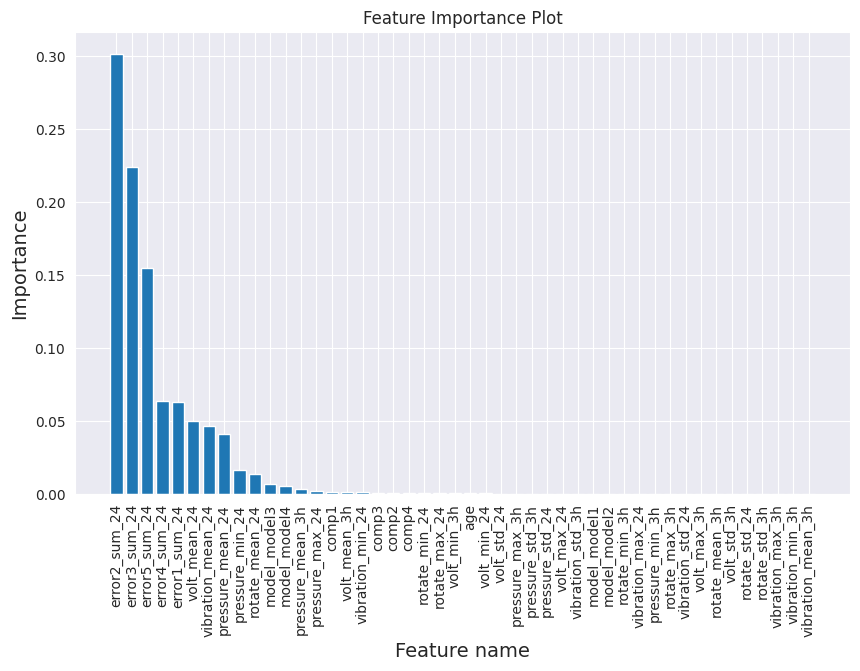

In [60]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

<a class="anchor" id="Model48_lag3"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Modify Features and Model for 48 hour prediction with 3 hour lag</h2>
</div>

In [61]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 48
error_count48 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count48.describe()

,machineID,datetime,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48
count,290600.00000,290600,290600.000000,290600.000000,290600.000000,290600.000000,290600.000000
mean,50.50000,2015-07-03 19:30:00,0.055286,0.054219,0.045847,0.039876,0.019532
min,1.00000,2015-01-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,3.000000,3.000000,3.000000,3.000000,2.000000
std,28.86612,NaN,0.235128,0.232626,0.214305,0.199707,0.139993


In [62]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
window = 48
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 3 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 48 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat48 = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,pressure_min_48,vibration_min_48,volt_max_48,rotate_max_48,pressure_max_48,vibration_max_48,volt_std_48,rotate_std_48,pressure_std_48,vibration_std_48
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.770861,446.617765,100.855611,40.383571,158.072102,404.144008,92.377658,36.146643,...,77.991152,29.004879,204.659470,560.129490,123.780454,51.762518,15.078531,50.609666,10.242839,5.082678
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,181.753428,394.815545,106.860209,43.561144,8.572887,28.916424,5.585285,2.883879
25%,25.75000,2015-04-04 00:00:00,164.445707,427.568132,96.239153,38.147287,150.362703,379.506058,86.861829,33.457012,...,74.989861,27.519031,198.926351,543.920198,119.222860,49.645879,13.932484,46.601414,9.299824,4.651623
50%,50.50000,2015-07-03 18:00:00,170.430366,448.389150,100.233244,40.146063,158.164123,406.885218,92.114226,36.087767,...,78.294864,29.155074,203.433530,558.788422,122.262331,51.164197,15.004424,50.173468,10.020070,5.011135
75%,75.25000,2015-10-02 12:00:00,176.605921,468.444197,104.404540,42.226863,165.837143,432.058039,97.272277,38.666230,...,81.234961,30.600113,209.063843,574.852679,126.072449,53.034300,16.132925,53.991995,10.803847,5.401454
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,117.635969,52.083159,255.124717,695.020984,185.951998,76.791072,29.530469,104.933839,28.251997,11.419040
std,28.86612,NaN,9.497163,33.117121,7.408122,3.475394,11.871843,40.808434,8.774756,4.205752,...,5.115899,2.503011,8.283306,24.893229,7.278493,3.244980,1.679652,6.018818,1.586619,0.672638


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Merge all the 48 hour lag feature with telemetry data sets</h2>

In [63]:
mach_feature48 = telemetry_lagfeat48.merge(error_count48, on=['datetime', 'machineID'], how='left') 
mach_feature48 = mach_feature48.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature48 = mach_feature48.merge(machines, on=['machineID'], how='left')
mach_feature48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.770861,446.617765,100.855611,40.383571,158.072102,404.144008,92.377658,36.146643,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.445707,427.568132,96.239153,38.147287,150.362703,379.506058,86.861829,33.457012,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.430366,448.389150,100.233244,40.146063,158.164123,406.885218,92.114226,36.087767,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.605921,468.444197,104.404540,42.226863,165.837143,432.058039,97.272277,38.666230,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497163,33.117121,7.408122,3.475394,11.871843,40.808434,8.774756,4.205752,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels for 48 hours prediction</h2>



</div>

In [64]:
labeled_features48 = create_labels(mach_feature48,failures_without_duplicates,
                  dup_dfs,fill_hrs=48, laghrs=3)

In [65]:
labeled_features48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,293773.000000,293773,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,...,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.00000,293773.000000,293773.000000,293773.000000
mean,50.445494,2015-07-03 16:08:22.796376576,170.790245,446.512390,100.870941,40.396170,158.090732,404.032496,92.393101,36.158354,...,0.055536,0.054944,0.046621,0.040136,0.020138,1286.607932,1232.98408,1257.286272,1288.180166,11.356153
min,1.000000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 21:00:00,164.455985,427.470843,96.241837,38.148640,150.369681,379.383225,86.863776,33.460181,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,291.00000,312.000000,312.000000,7.000000
50%,50.000000,2015-07-03 18:00:00,170.442311,448.345582,100.236399,40.151027,158.176562,406.833037,92.119193,36.092002,...,0.000000,0.000000,0.000000,0.000000,0.000000,789.000000,711.00000,771.000000,780.000000,12.000000
75%,75.000000,2015-10-02 09:00:00,176.622890,468.413466,104.409888,42.236717,165.855559,432.008900,97.283351,38.675616,...,0.000000,0.000000,0.000000,0.000000,0.000000,1647.000000,1593.00000,1605.000000,1680.000000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.00000,8901.000000,9477.000000,20.000000
std,28.896581,NaN,9.518806,33.247801,7.441333,3.494526,11.889141,40.923760,8.804172,4.220329,...,0.235704,0.234061,0.216026,0.200449,0.142039,1506.088283,1417.87727,1405.132303,1429.977779,5.820450


In [66]:
telemetry.describe()

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [67]:
labeled_features48[
    #(labeled_features48['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features48['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_features48['datetime'] > pd.to_datetime('2015-03-16 06:00:00')) &   # Lower bound
    (labeled_features48['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,model,age,failure
3482,2,2015-03-16 09:00:00,177.647712,381.587333,92.124419,36.258825,169.430378,340.377620,85.115138,30.695417,...,0.0,0.0,0.0,6555.0,5115.0,651.0,291.0,model4,7,none
3483,2,2015-03-16 12:00:00,175.137414,450.531680,92.691694,37.881644,165.213940,385.919920,87.754292,32.884547,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
3484,2,2015-03-16 15:00:00,160.706203,426.272390,93.487327,42.071604,148.069009,415.588728,87.380976,37.502139,...,0.0,0.0,0.0,6561.0,5121.0,657.0,297.0,model4,7,none
3485,2,2015-03-16 18:00:00,179.260992,505.640507,105.042079,43.656963,176.062170,497.545704,93.007327,40.871406,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
3486,2,2015-03-16 21:00:00,174.631190,389.350672,103.229892,38.830162,170.977717,361.265870,97.274272,34.493067,...,0.0,0.0,0.0,6567.0,5127.0,663.0,303.0,model4,7,none
3487,2,2015-03-17 00:00:00,168.392120,456.583436,93.337372,39.187217,158.903412,426.960868,83.241529,37.788793,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
3488,2,2015-03-17 03:00:00,181.998415,433.087627,92.204539,39.509945,167.580403,418.992300,90.914233,34.695831,...,0.0,0.0,0.0,6573.0,5133.0,669.0,309.0,model4,7,none
3489,2,2015-03-17 06:00:00,164.421135,461.543033,112.281228,46.262045,154.044511,376.318539,109.197789,42.344200,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none
3490,2,2015-03-17 09:00:00,191.877454,371.051731,96.072228,41.693572,175.643659,321.623599,84.842255,36.297268,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,comp1
3491,2,2015-03-17 12:00:00,182.461251,373.972592,104.486993,43.968925,161.932600,327.363472,97.749591,40.654986,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,comp1


In [68]:
X = labeled_features48.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_features48['failure']

   volt_mean_3h  rotate_mean_3h  pressure_mean_3h  vibration_mean_3h  \
0    181.690108      472.783187         93.395164          38.621099   
1    172.382935      505.141261         98.524373          49.965572   
2    174.303858      436.182686         94.092681          50.999589   
3    176.246348      451.646684         98.102389          59.198241   
4    158.433533      453.900213         98.878129          46.851925   

   volt_min_3h  rotate_min_3h  pressure_min_3h  vibration_min_3h  volt_max_3h  \
0   174.138401     418.842271        91.926306         32.323616   194.942847   
1   164.341435     459.956670        94.488533         47.875804   177.594089   
2   156.866113     405.869840        85.246610         47.698464   194.581170   
3   166.480684     427.675888        87.874871         55.062110   190.431960   
4   154.199258     429.822144        85.755546         43.788682   164.148095   

   rotate_max_3h  ...  error5_sum_48  comp1   comp2   comp3   comp4  age  \
0   

In [69]:
%%time
def random_search_pipeline(X_train, y_train):
    # Use XGBoost as it outperformed other classifiers in 24 hour prediction model and DF structure similar
    x_cfl=XGBClassifier()

    # Define the parameter grid
    param_grid =  {
            'n_estimators':[100, 500, 1000],
            'learning_rate': [0.1, 0.15, 0.2],  
            'max_depth': [3, 6, 10],              
            'colsample_bytree':[0.1, 0.3,0.5,1],
            'subsample':[0.1, 0.3,0.5,1]
        }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(x_cfl, param_distributions=param_grid, cv=tscv, n_iter=15, verbose=10, n_jobs=-1)

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = random_search.best_estimator_
    return random_search

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 9.54 µs


In [70]:
%%time
def random_search_pipelineTest(X_train, y_train):
    # Use XGBoost as it outperformed other classifiers in 24 hour prediction model
    x_cfl=XGBClassifier()

    # Define the parameter grid
    param_grid =  {
            'n_estimators':[100], #[500, 1000],
            'learning_rate': [0.1], # 0.15, 0.2],   # [0.1, 0.5, 1]
            'max_depth': [3], # 6, 10],              #[5, 10, 20]
            'colsample_bytree':[0.1], #0.3,0.5,1],
            'subsample':[0.1] #,0.3,0.5,1]
        }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(x_cfl, param_distributions=param_grid, cv=tscv, n_iter=15, verbose=10, n_jobs=-1)

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = random_search.best_estimator_
    return random_search

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

In [72]:
yn_train = label_encoder.fit_transform(y_train)
random_search=random_search_pipeline(X_train, yn_train)
best_estimator = random_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 58/63] END clfr=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), clfr__learning_rate=0.15, clfr__max_depth=6, clfr__n_estimators=500;, score=0.997 total time= 1.4min
[CV 3/3; 58/63] START clfr=XGBClassifier(base_score=No

In [73]:
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model48_3hr = calc_acc_prec_recall(y_test,y_pred)

Confusion Matrix:
       comp1  comp2  comp3  comp4   none
comp1    432     18      8     32    134
comp2     21    625      0     55    179
comp3      7      2    637      7     19
comp4      0     18     10    495     37
none      37     55     90     67  55770

Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
   Class  Precision
0  comp1   0.869215
1  comp2   0.870474
2  comp3   0.855034
3  comp4   0.754573
4   none   0.993427

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
   Class    Recall
0  comp1  0.692308
1  comp2  0.710227
2  comp3  0.947917
3  comp4  0.883929
4   none  0.995555


In [74]:
'''
table48_3hr = PrettyTable()
table48_3hr.add_row(["48hr 3hr","XGBClassifier","1",round(random_search.best_score_,4),random_search.best_params_])'''
table48_3hr = pd.DataFrame(["48hr 3hr","XGBClassifier","1",round(random_search.best_score_,4),random_search.best_params_]).T
table48_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
print(table48_3hr)

  Pred/lag hour     Classifier Rank    Mean  \
0      48hr 3hr  XGBClassifier    1  0.9876   

                                                                                             Parameters  
0  {'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1}  


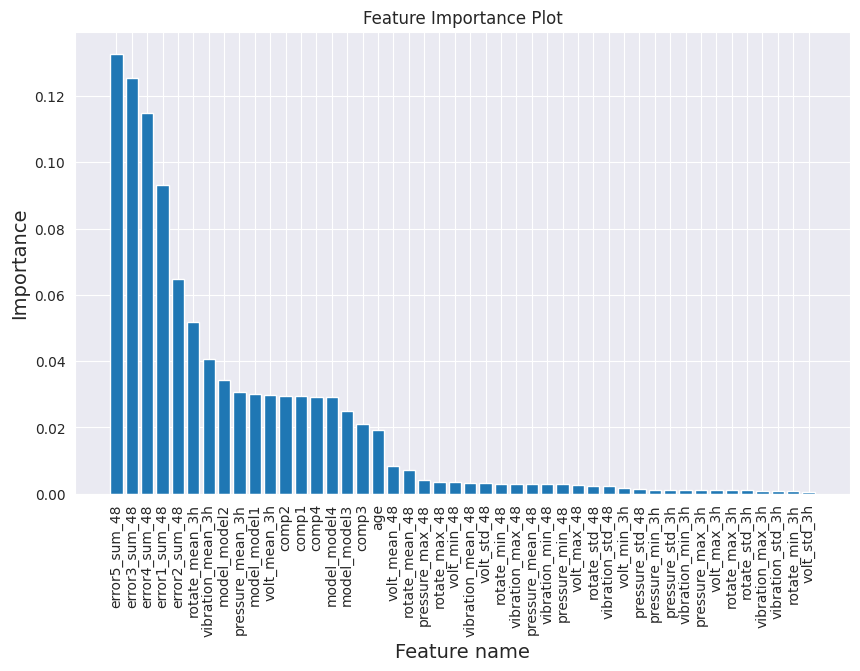

In [75]:
feature_importance_plot(X_test,best_estimator)

<a class="anchor" id="Model48_lag6"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Model for 48 hour prediction with 6 hour lag</h2>



</div>

In [76]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '6H'
window = 48
error_count48 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count48.describe()

,machineID,datetime,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48
count,145400.000000,145400,145400.000000,145400.000000,145400.000000,145400.000000,145400.000000
mean,50.500000,2015-07-03 21:00:00,0.055303,0.054209,0.045839,0.039862,0.019532
min,1.000000,2015-01-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-03 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-02 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 12:00:00,3.000000,3.000000,3.000000,3.000000,2.000000
std,28.866169,NaN,0.235185,0.232604,0.214302,0.199639,0.139968


In [77]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '6H'
window = 48
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 6 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 48 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat48 = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat48.describe()

,machineID,datetime,volt_mean_6h,rotate_mean_6h,pressure_mean_6h,vibration_mean_6h,volt_min_6h,rotate_min_6h,pressure_min_6h,vibration_min_6h,...,pressure_min_48,vibration_min_48,volt_max_48,rotate_max_48,pressure_max_48,vibration_max_48,volt_std_48,rotate_std_48,pressure_std_48,vibration_std_48
count,145300.000000,145300,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,...,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000
mean,50.500000,2015-07-03 18:00:00,170.770543,446.616807,100.855926,40.383627,151.745900,383.035830,88.136863,34.031047,...,77.996750,29.006319,204.657534,560.113277,123.779894,51.762095,15.078428,50.605904,10.242269,5.082456
min,1.000000,2015-01-03 06:00:00,138.519598,231.248012,80.653505,30.976492,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,181.753428,394.815545,107.119609,43.800007,9.118572,28.916424,5.643521,2.883879
25%,25.750000,2015-04-04 00:00:00,166.082666,433.947580,97.321193,38.689287,145.161939,362.432461,83.413447,31.716442,...,74.989861,27.519031,198.922894,543.908541,119.223470,49.646164,13.930800,46.607012,9.298366,4.652115
50%,50.500000,2015-07-03 18:00:00,170.286815,448.831513,100.164220,40.107178,151.938049,386.368695,87.919077,33.980290,...,78.297811,29.155190,203.434440,558.777761,122.258876,51.163490,15.006532,50.176365,10.018921,5.011386
75%,75.250000,2015-10-02 12:00:00,174.750799,463.055940,103.123431,41.584642,158.405539,407.871542,92.266151,36.177234,...,81.234427,30.599167,209.063918,574.852679,126.072138,53.031514,16.134122,53.974445,10.802969,5.401401
max,100.000000,2016-01-01 06:00:00,225.320545,542.011094,158.709038,64.026600,217.580925,508.303634,151.428106,60.516184,...,117.635969,52.083159,255.124717,695.020984,185.951998,76.791072,29.530469,104.933839,28.251997,11.419040
std,28.866169,NaN,7.242045,25.973946,6.152021,2.801897,10.387196,36.139774,7.861954,3.742909,...,5.134933,2.507517,8.283033,24.935649,7.276278,3.245385,1.680897,6.017150,1.587150,0.672864


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Merge all the 48 hour lag feature with telemetry data sets</h2>

In [78]:
mach_feature48 = telemetry_lagfeat48.merge(error_count48, on=['datetime', 'machineID'], how='left') # remove error_count24
mach_feature48 = mach_feature48.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature48 = mach_feature48.merge(machines, on=['machineID'], how='left')
mach_feature48.describe()

,machineID,datetime,volt_mean_6h,rotate_mean_6h,pressure_mean_6h,vibration_mean_6h,volt_min_6h,rotate_min_6h,pressure_min_6h,vibration_min_6h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,145300.000000,145300,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,...,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000,145300.000000
mean,50.500000,2015-07-03 18:00:00,170.770543,446.616807,100.855926,40.383627,151.745900,383.035830,88.136863,34.031047,...,0.055341,0.054233,0.045836,0.039869,0.019546,1275.984529,1225.857233,1254.796476,1281.084487,11.330000
min,1.000000,2015-01-03 06:00:00,138.519598,231.248012,80.653505,30.976492,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-04 00:00:00,166.082666,433.947580,97.321193,38.689287,145.161939,362.432461,83.413447,31.716442,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,306.000000,6.750000
50%,50.500000,2015-07-03 18:00:00,170.286815,448.831513,100.164220,40.107178,151.938049,386.368695,87.919077,33.980290,...,0.000000,0.000000,0.000000,0.000000,0.000000,780.000000,708.000000,768.000000,774.000000,12.000000
75%,75.250000,2015-10-02 12:00:00,174.750799,463.055940,103.123431,41.584642,158.405539,407.871542,92.266151,36.177234,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1578.000000,1602.000000,1674.000000,16.000000
max,100.000000,2016-01-01 06:00:00,225.320545,542.011094,158.709038,64.026600,217.580925,508.303634,151.428106,60.516184,...,3.000000,3.000000,3.000000,3.000000,2.000000,11802.000000,8370.000000,8898.000000,9474.000000,20.000000
std,28.866169,NaN,7.242045,25.973946,6.152021,2.801897,10.387196,36.139774,7.861954,3.742909,...,0.235262,0.232653,0.214299,0.199657,0.140015,1496.276972,1416.236677,1407.748273,1428.000803,5.827635


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels for 48 hours prediction</h2>



</div>

In [79]:
labeled_features48 = create_labels(mach_feature48,failures_without_duplicates,
                  dup_dfs,fill_hrs=48, laghrs=6)

In [80]:
labeled_features48.describe()

,machineID,datetime,volt_mean_6h,rotate_mean_6h,pressure_mean_6h,vibration_mean_6h,volt_min_6h,rotate_min_6h,pressure_min_6h,vibration_min_6h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,146957.000000,146957,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,...,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000,146957.000000
mean,50.444770,2015-07-03 16:06:32.098369024,170.790041,446.511591,100.871142,40.396288,151.763586,382.923825,88.152905,34.043502,...,0.055581,0.054941,0.046619,0.040134,0.020142,1284.983553,1231.341576,1255.646482,1286.487503,11.356458
min,1.000000,2015-01-03 06:00:00,138.519598,231.248012,80.653505,30.976492,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-04 00:00:00,166.088077,433.875798,97.322917,38.690472,145.163943,362.311687,83.415901,31.719511,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,312.000000,7.000000
50%,50.000000,2015-07-03 18:00:00,170.296826,448.794739,100.166917,40.110760,151.950755,386.308931,87.925442,33.983253,...,0.000000,0.000000,0.000000,0.000000,0.000000,786.000000,708.000000,768.000000,780.000000,12.000000
75%,75.000000,2015-10-02 12:00:00,174.764767,463.034155,103.125230,41.591746,158.421339,407.851738,92.275614,36.185426,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1602.000000,1680.000000,16.000000
max,100.000000,2016-01-01 06:00:00,225.320545,542.011094,158.709038,64.026600,217.580925,508.303634,151.428106,60.516184,...,3.000000,3.000000,3.000000,3.000000,2.000000,11802.000000,8370.000000,8898.000000,9474.000000,20.000000
std,28.897013,NaN,7.268970,26.142188,6.192398,2.825339,10.404116,36.280511,7.894252,3.760143,...,0.235815,0.234054,0.216051,0.200392,0.142028,1506.061674,1417.772381,1404.983280,1429.835451,5.820369


In [81]:
telemetry.describe()

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [82]:
labeled_features48[
    #(labeled_features48['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features48['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_features48['datetime'] > pd.to_datetime('2015-03-16 00:00:00')) &   # Lower bound
    (labeled_features48['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_6h,rotate_mean_6h,pressure_mean_6h,vibration_mean_6h,volt_min_6h,rotate_min_6h,pressure_min_6h,vibration_min_6h,...,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,model,age,failure
1741,2,2015-03-16 06:00:00,160.846687,456.031548,107.070021,39.779199,149.175544,390.172498,99.809224,36.252666,...,0.0,0.0,0.0,6552.0,5112.0,648.0,288.0,model4,7,none
1742,2,2015-03-16 12:00:00,176.392563,416.059506,92.408057,37.070235,165.213940,340.377620,85.115138,30.695417,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
1743,2,2015-03-16 18:00:00,169.983597,465.956448,99.264703,42.864284,148.069009,415.588728,87.380976,37.502139,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
1744,2,2015-03-17 00:00:00,171.511655,422.967054,98.283632,39.008690,158.903412,361.265870,83.241529,34.493067,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
1745,2,2015-03-17 06:00:00,173.209775,447.315330,102.242884,42.885995,154.044511,376.318539,90.914233,34.695831,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none
1746,2,2015-03-17 12:00:00,187.169352,372.512162,100.279611,42.831249,161.932600,321.623599,84.842255,36.297268,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,comp1
1747,2,2015-03-17 18:00:00,196.831095,364.127492,99.074971,41.039651,183.855583,291.094371,85.973884,31.769829,...,0.0,0.0,0.0,6588.0,5148.0,684.0,324.0,model4,7,comp1
1748,2,2015-03-18 00:00:00,187.289531,372.021429,98.317151,42.507069,168.768124,276.151681,81.848081,35.790437,...,0.0,0.0,0.0,6594.0,5154.0,690.0,330.0,model4,7,comp1
1749,2,2015-03-18 06:00:00,189.793550,369.873475,98.042934,42.684539,174.788266,335.065946,87.934106,39.589868,...,0.0,0.0,0.0,6600.0,5160.0,696.0,336.0,model4,7,comp1
1750,2,2015-03-18 12:00:00,190.371648,361.718138,97.625220,41.069689,168.448450,310.368039,89.573491,34.848273,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comp1


In [83]:
X = labeled_features48.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_features48['failure']

   volt_mean_6h  rotate_mean_6h  pressure_mean_6h  vibration_mean_6h  \
0    178.450068      488.814309        100.953658          38.192516   
1    173.343396      470.661974         96.308527          50.482580   
2    167.339940      452.773449         98.490259          53.025083   
3    168.315573      424.569236         96.240487          50.596187   
4    181.268128      455.585037        109.922327          55.302065   

   volt_min_6h  rotate_min_6h  pressure_min_6h  vibration_min_6h  volt_max_6h  \
0   168.373525     418.842271        91.926306         32.323616   194.942847   
1   156.866113     405.869840        85.246610         47.698464   194.581170   
2   154.199258     427.675888        85.755546         43.788682   190.431960   
3   157.289749     374.127148        87.685418         39.273567   179.369497   
4   165.187401     384.138905       103.742947         49.657392   195.564941   

   rotate_max_6h  ...  error5_sum_48  comp1   comp2   comp3   comp4  age  \
0   

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

In [85]:
yn_train = label_encoder.fit_transform(y_train)
random_search=random_search_pipeline(X_train, yn_train)
best_estimator = random_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 3/3; 1/15] START colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1
[CV 3/3; 1/15] END colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1;, score=0.989 total time=  42.0s
[CV 1/3; 3/15] START colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1
[CV 1/3; 3/15] END colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=0.968 total time=  18.0s
[CV 2/3; 3/15] START colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1
[CV 2/3; 3/15] END colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=0.978 total time=  34.0s
[CV 3/3; 3/15] START colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1
[CV 3/3; 3/15] END colsample_bytree=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, 

In [86]:
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model48_6hr = calc_acc_prec_recall(y_test,y_pred)

Confusion Matrix:
       comp1  comp2  comp3  comp4   none
comp1    234     16      5     16     41
comp2      6    356      0     18     60
comp3      3      0    326      4      3
comp4      0     16      7    246     11
none      14     28     29     20  27933

Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
   Class  Precision
0  comp1   0.910506
1  comp2   0.855769
2  comp3   0.888283
3  comp4   0.809211
4   none   0.995900

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
   Class    Recall
0  comp1  0.750000
1  comp2  0.809091
2  comp3  0.970238
3  comp4  0.878571
4   none  0.996753


In [87]:
'''table48_6hr = PrettyTable()
table48_6hr.add_row(["48hr 6hr","XGBClassifier","1",round(random_search.best_score_,4),random_search.best_params_])'''
table48_6hr = pd.DataFrame(["48hr 6hr","XGBClassifier","1",round(random_search.best_score_,4),random_search.best_params_]).T
table48_6hr.columns= ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"] 
display(table48_6hr)

,Pred/lag hour,Classifier,Rank,Mean,Parameters
0,48hr 6hr,XGBClassifier,1,0.9897,"{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.5}"


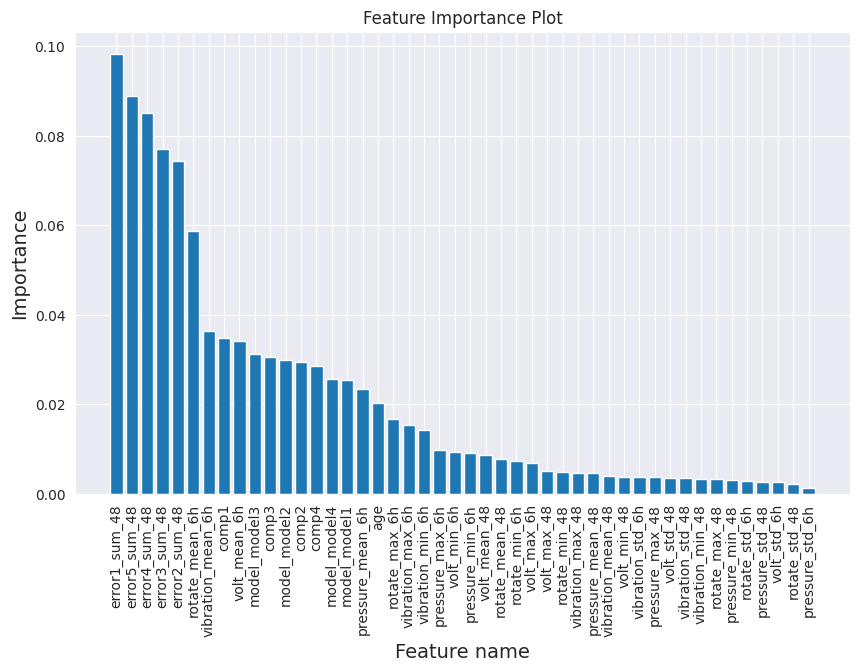

In [88]:
feature_importance_plot(X_test,best_estimator)

<a class="anchor" id="Model24_shift_lag"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">24 hrs window 3 hr shift columns lag</h2>
</div>

In [89]:
aggrs = ['mean']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
# Calculate 'mean' over the last 3 hour lag window
# for telemetry features 
telemetry_feat_mean = resample_feat_rule(telemetry, features, rule, aggrs)

In [90]:
def telemetry_shift_columns(telemetry_mean, pred_hours):
    # Drop 'machineID' and 'datetime' as they must not be in shifted columns
    telemetry_mean_only = telemetry_mean.drop(labels=['machineID','datetime'], axis=1)

    # Shift columns and store them in a list, rename the columns of each shifted DataFrame generated
    # Example for 24 hours use
    # 24, 18 .. 3 hours by adding suffixes like "_24", "_18",and so on, corresponding to the number
    # calculated based on the iteration. This assumes lag 3 hour averages
    shifted_columns = [telemetry_mean_only.shift(i).add_suffix("_"+str(i * 3 + 3))
                       for i in range(int(pred_hours/3)-1, -1, -1)]
    # Concatenate the shifted columns along the columns (axis=1)
    telemetry_mean_Shift = pd.concat(shifted_columns, axis=1)
    # Concatenate the telemetry mean datetime and machineID to telemetry_feat_mean_Shift24 and dropna
    return pd.concat([telemetry_mean.iloc[:,:2],telemetry_mean_Shift],axis=1).dropna()

In [91]:
# Shift columns
telemetry_feat_shift_lag24 = telemetry_shift_columns(telemetry_feat_mean, pred_hours=24)
telemetry_feat_shift_lag24

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,pressure_mean_3h_9,vibration_mean_3h_9,volt_mean_3h_6,rotate_mean_3h_6,pressure_mean_3h_6,vibration_mean_3h_6,volt_mean_3h_3,rotate_mean_3h_3,pressure_mean_3h_3,vibration_mean_3h_3
7,1,2015-01-02 06:00:00,170.028993,449.533798,94.592122,40.893502,164.192565,403.949857,105.687417,34.255891,...,90.446472,41.796657,172.277489,477.738628,89.104865,41.232001,180.133784,440.608320,94.137969,41.551544
8,1,2015-01-02 09:00:00,164.192565,403.949857,105.687417,34.255891,168.134445,435.781707,107.793709,41.239405,...,89.104865,41.232001,180.133784,440.608320,94.137969,41.551544,176.364293,439.349655,101.553209,36.105580
9,1,2015-01-02 12:00:00,168.134445,435.781707,107.793709,41.239405,165.514453,430.472823,101.703289,40.373739,...,94.137969,41.551544,176.364293,439.349655,101.553209,36.105580,160.384568,424.385316,99.598722,36.094637
10,1,2015-01-02 15:00:00,165.514453,430.472823,101.703289,40.373739,168.809347,437.111120,90.911060,41.738542,...,101.553209,36.105580,160.384568,424.385316,99.598722,36.094637,170.472461,442.933997,102.380586,40.483002
11,1,2015-01-02 18:00:00,168.809347,437.111120,90.911060,41.738542,168.779396,486.242664,90.446472,41.796657,...,99.598722,36.094637,170.472461,442.933997,102.380586,40.483002,163.263806,468.937558,102.726648,40.921802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,160.093725,418.468730,103.425431,36.685150,153.108292,446.710462,105.795285,38.450196,...,100.891981,36.788042,177.758754,458.391629,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459
292096,100,2016-01-01 00:00:00,153.108292,446.710462,105.795285,38.450196,156.507808,490.798016,98.534959,40.310998,...,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,156.507808,490.798016,98.534959,40.310998,176.040842,518.996046,97.541077,39.385324,...,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,176.040842,518.996046,97.541077,39.385324,190.802419,469.677266,102.422640,37.816891,...,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232,182.525427,435.932056,98.798172,42.757630


In [92]:
telemetry_feat_shift_lag24.columns.tolist()

['machineID',
 'datetime',
 'volt_mean_3h_24',
 'rotate_mean_3h_24',
 'pressure_mean_3h_24',
 'vibration_mean_3h_24',
 'volt_mean_3h_21',
 'rotate_mean_3h_21',
 'pressure_mean_3h_21',
 'vibration_mean_3h_21',
 'volt_mean_3h_18',
 'rotate_mean_3h_18',
 'pressure_mean_3h_18',
 'vibration_mean_3h_18',
 'volt_mean_3h_15',
 'rotate_mean_3h_15',
 'pressure_mean_3h_15',
 'vibration_mean_3h_15',
 'volt_mean_3h_12',
 'rotate_mean_3h_12',
 'pressure_mean_3h_12',
 'vibration_mean_3h_12',
 'volt_mean_3h_9',
 'rotate_mean_3h_9',
 'pressure_mean_3h_9',
 'vibration_mean_3h_9',
 'volt_mean_3h_6',
 'rotate_mean_3h_6',
 'pressure_mean_3h_6',
 'vibration_mean_3h_6',
 'volt_mean_3h_3',
 'rotate_mean_3h_3',
 'pressure_mean_3h_3',
 'vibration_mean_3h_3']

In [93]:
mach_feature_shift_lag24 = telemetry_feat_shift_lag24.merge(error_count24, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.merge(machines, on=['machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.dropna()
mach_feature_shift_lag24.describe()

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.772603,446.611942,100.854485,40.384524,170.772841,446.613100,100.854284,40.384579,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.447482,427.565810,96.238546,38.147538,164.447482,427.568513,96.238173,38.147605,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.431581,448.385986,100.233037,40.145749,170.432551,448.388493,100.233022,40.145741,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.606663,468.445078,104.404569,42.226768,176.606488,468.445387,104.404588,42.226810,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.496265,33.126895,7.405423,3.478695,9.496432,33.127281,7.404960,3.478404,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>
</div>

In [94]:
labeled_feature_shift_lag24 = create_labels(mach_feature_shift_lag24,failures_without_duplicates,
                  dup_dfs,fill_hrs=24, laghrs=3)

In [95]:
labeled_feature_shift_lag24.columns.to_list()
labeled_feature_shift_lag24.describe()

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,294581.000000,294581,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,...,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000,294581.000000
mean,50.444598,2015-07-03 04:09:35.132815616,170.782814,446.557463,100.861547,40.392094,170.783928,446.549701,100.862599,40.392896,...,0.028016,0.027806,0.023637,0.020181,0.010381,1289.377129,1237.241709,1261.202847,1292.361354,11.356018
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 03:00:00,164.452887,427.513801,96.240271,38.148223,164.453212,427.509240,96.240380,38.148329,...,0.000000,0.000000,0.000000,0.000000,0.000000,321.000000,291.000000,315.000000,312.000000,7.000000
50%,50.000000,2015-07-03 06:00:00,170.437842,448.368165,100.234223,40.148372,170.439189,448.365296,100.234519,40.148648,...,0.000000,0.000000,0.000000,0.000000,0.000000,792.000000,711.000000,774.000000,783.000000,12.000000
75%,75.000000,2015-10-02 03:00:00,176.614963,468.428739,104.406074,42.232411,176.615782,468.426962,104.407085,42.233270,...,0.000000,0.000000,0.000000,0.000000,0.000000,1650.000000,1602.000000,1611.000000,1689.000000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.896801,NaN,9.508209,33.195586,7.421295,3.490767,9.509315,33.209134,7.422758,3.491643,...,0.167429,0.166610,0.153759,0.141822,0.101858,1507.627488,1420.892446,1407.657587,1432.382356,5.820403


In [96]:
labeled_feature_shift_lag24[
    #(labeled_feature_shift_lag24['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_feature_shift_lag24['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_feature_shift_lag24['datetime'] > pd.to_datetime('2015-03-17 06:00:00')) &   # Lower bound
    (labeled_feature_shift_lag24['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3506,2,2015-03-17 09:00:00,175.137414,450.531680,92.691694,37.881644,160.706203,426.272390,93.487327,42.071604,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,none
3507,2,2015-03-17 12:00:00,160.706203,426.272390,93.487327,42.071604,179.260992,505.640507,105.042079,43.656963,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,none
3508,2,2015-03-17 15:00:00,179.260992,505.640507,105.042079,43.656963,174.631190,389.350672,103.229892,38.830162,...,0.0,0.0,0.0,6585.0,5145.0,681.0,321.0,model4,7,none
3509,2,2015-03-17 18:00:00,174.631190,389.350672,103.229892,38.830162,168.392120,456.583436,93.337372,39.187217,...,0.0,0.0,0.0,6588.0,5148.0,684.0,324.0,model4,7,none
3510,2,2015-03-17 21:00:00,168.392120,456.583436,93.337372,39.187217,181.998415,433.087627,92.204539,39.509945,...,0.0,0.0,0.0,6591.0,5151.0,687.0,327.0,model4,7,none
3511,2,2015-03-18 00:00:00,181.998415,433.087627,92.204539,39.509945,164.421135,461.543033,112.281228,46.262045,...,0.0,0.0,0.0,6594.0,5154.0,690.0,330.0,model4,7,none
3512,2,2015-03-18 03:00:00,164.421135,461.543033,112.281228,46.262045,191.877454,371.051731,96.072228,41.693572,...,0.0,0.0,0.0,6597.0,5157.0,693.0,333.0,model4,7,none
3513,2,2015-03-18 06:00:00,191.877454,371.051731,96.072228,41.693572,182.461251,373.972592,104.486993,43.968925,...,0.0,0.0,0.0,6600.0,5160.0,696.0,336.0,model4,7,none
3514,2,2015-03-18 09:00:00,182.461251,373.972592,104.486993,43.968925,205.910271,403.503659,99.287823,44.496410,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comp1
3515,2,2015-03-18 12:00:00,205.910271,403.503659,99.287823,44.496410,187.751919,324.751326,98.862119,37.582892,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comp1


In [97]:
X = labeled_feature_shift_lag24.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_feature_shift_lag24['failure']

   volt_mean_3h_24  rotate_mean_3h_24  pressure_mean_3h_24  \
0       170.028993         449.533798            94.592122   
1       164.192565         403.949857           105.687417   
2       168.134445         435.781707           107.793709   
3       165.514453         430.472823           101.703289   
4       168.809347         437.111120            90.911060   

   vibration_mean_3h_24  volt_mean_3h_21  rotate_mean_3h_21  \
0             40.893502       164.192565         403.949857   
1             34.255891       168.134445         435.781707   
2             41.239405       165.514453         430.472823   
3             40.373739       168.809347         437.111120   
4             41.738542       168.779396         486.242664   

   pressure_mean_3h_21  vibration_mean_3h_21  volt_mean_3h_18  \
0           105.687417             34.255891       168.134445   
1           107.793709             41.239405       165.514453   
2           101.703289             40.373739       16

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

In [99]:
yn_train = label_encoder.fit_transform(y_train)
grid_search = grid_search_pipeline(X_train,  yn_train)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV 2/3; 1/15] START colsample_bytree=0.1, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.1
[CV 2/3; 1/15] END colsample_bytree=0.1, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.1;, score=0.981 total time= 2.9min
[CV 2/3; 3/15] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=1
[CV 2/3; 3/15] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=1;, score=0.991 total time= 1.9min
[CV 1/3; 6/15] START colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.1
[CV 1/3; 6/15] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.1;, score=0.980 total time=  45.4s
[CV 1/3; 7/15] START colsample_bytree=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.3
[CV 1/3; 7/15] END colsample_bytree=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.3;, score=0.975 total time=  53.3s
[CV 1/3; 8/15] S

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Libl

[CV 3/3; 1/15] START colsample_bytree=0.1, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.1
[CV 3/3; 1/15] END colsample_bytree=0.1, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.1;, score=0.983 total time= 4.6min
[CV 2/3; 5/15] START colsample_bytree=0.1, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.5
[CV 2/3; 5/15] END colsample_bytree=0.1, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.5;, score=0.984 total time=  18.6s
[CV 2/3; 6/15] START colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.1
[CV 2/3; 6/15] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.1;, score=0.987 total time= 1.6min
[CV 3/3; 7/15] START colsample_bytree=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.3
[CV 3/3; 7/15] END colsample_bytree=0.1, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.3;, score=0.985 total time= 2.7min
[CV 1/3; 12/15

In [100]:
best_estimator=grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model24_shift_3hr = calc_acc_prec_recall(y_test,y_pred)

Confusion Matrix:
       comp1  comp2  comp3  comp4   none
comp1    290      5      8      9      0
comp2     11    415      0     14      0
comp3      0      0    336      0      0
comp4      7     18      8    247      0
none      16      1      9      8  57515

Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
   Class  Precision
0  comp1   0.895062
1  comp2   0.945330
2  comp3   0.930748
3  comp4   0.888489
4   none   1.000000

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
   Class    Recall
0  comp1  0.929487
1  comp2  0.943182
2  comp3  1.000000
3  comp4  0.882143
4   none  0.999409


In [101]:
table24_shift_3hr = create_pretty_table(grid_search,"24hr 3hr Shift")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
2,24hr 3hr Shift,XGBClassifier,1,0.9988,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
0,24hr 3hr Shift,RandomForestClassifier,13,0.9984,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
1,24hr 3hr Shift,Pipeline,17,0.9966,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 1, 'clfr__lsvc__loss': 'squared_hinge'}"
3,24hr 3hr Shift,HistGradientBoostingClassifier,35,0.9914,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 500}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

In [102]:
grid_search.best_estimator_.named_steps.clfr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

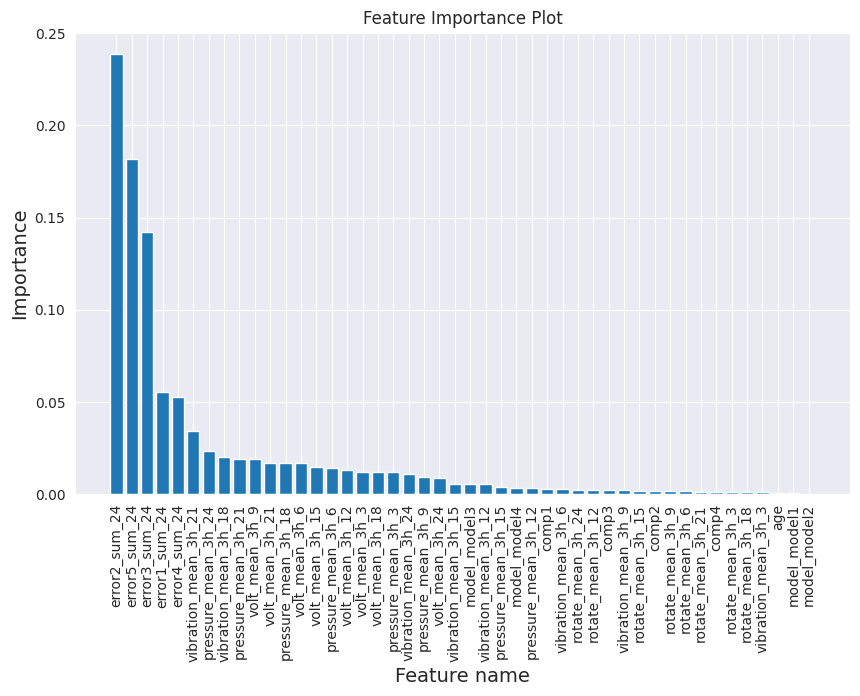

In [103]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

In [104]:
# Although

<a class="anchor" id="Model48_shift_lag"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">48 hrs window 3 hr shift columns lag</h2>
</div>

In [105]:
aggrs = ['mean']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
# Calculate 'mean' over the last 3 hour lag window
# for telemetry features 
telemetry_feat_mean = resample_feat_rule(telemetry, features, rule, aggrs)

In [106]:
# Shift columns
telemetry_feat_shift_lag48 = telemetry_shift_columns(telemetry_feat_mean, pred_hours=48)
telemetry_feat_shift_lag48

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,pressure_mean_3h_9,vibration_mean_3h_9,volt_mean_3h_6,rotate_mean_3h_6,pressure_mean_3h_6,vibration_mean_3h_6,volt_mean_3h_3,rotate_mean_3h_3,pressure_mean_3h_3,vibration_mean_3h_3
15,1,2015-01-03 06:00:00,170.028993,449.533798,94.592122,40.893502,164.192565,403.949857,105.687417,34.255891,...,93.747282,39.716482,175.210027,504.845430,108.512153,37.763933,181.690108,472.783187,93.395164,38.621099
16,1,2015-01-03 09:00:00,164.192565,403.949857,105.687417,34.255891,168.134445,435.781707,107.793709,41.239405,...,108.512153,37.763933,181.690108,472.783187,93.395164,38.621099,172.382935,505.141261,98.524373,49.965572
17,1,2015-01-03 12:00:00,168.134445,435.781707,107.793709,41.239405,165.514453,430.472823,101.703289,40.373739,...,93.395164,38.621099,172.382935,505.141261,98.524373,49.965572,174.303858,436.182686,94.092681,50.999589
18,1,2015-01-03 15:00:00,165.514453,430.472823,101.703289,40.373739,168.809347,437.111120,90.911060,41.738542,...,98.524373,49.965572,174.303858,436.182686,94.092681,50.999589,176.246348,451.646684,98.102389,59.198241
19,1,2015-01-03 18:00:00,168.809347,437.111120,90.911060,41.738542,168.779396,486.242664,90.446472,41.796657,...,94.092681,50.999589,176.246348,451.646684,98.102389,59.198241,158.433533,453.900213,98.878129,46.851925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,164.394679,438.937506,93.813332,37.178644,159.767735,456.564035,85.266748,40.989801,...,100.891981,36.788042,177.758754,458.391629,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459
292096,100,2016-01-01 00:00:00,159.767735,456.564035,85.266748,40.989801,167.674472,447.605461,91.239263,43.809642,...,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,167.674472,447.605461,91.239263,43.809642,163.440138,480.468668,106.363030,40.507265,...,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,163.440138,480.468668,106.363030,40.507265,179.723657,463.709612,97.933881,39.207487,...,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232,182.525427,435.932056,98.798172,42.757630


In [107]:
telemetry_feat_shift_lag48.columns.tolist()

['machineID',
 'datetime',
 'volt_mean_3h_48',
 'rotate_mean_3h_48',
 'pressure_mean_3h_48',
 'vibration_mean_3h_48',
 'volt_mean_3h_45',
 'rotate_mean_3h_45',
 'pressure_mean_3h_45',
 'vibration_mean_3h_45',
 'volt_mean_3h_42',
 'rotate_mean_3h_42',
 'pressure_mean_3h_42',
 'vibration_mean_3h_42',
 'volt_mean_3h_39',
 'rotate_mean_3h_39',
 'pressure_mean_3h_39',
 'vibration_mean_3h_39',
 'volt_mean_3h_36',
 'rotate_mean_3h_36',
 'pressure_mean_3h_36',
 'vibration_mean_3h_36',
 'volt_mean_3h_33',
 'rotate_mean_3h_33',
 'pressure_mean_3h_33',
 'vibration_mean_3h_33',
 'volt_mean_3h_30',
 'rotate_mean_3h_30',
 'pressure_mean_3h_30',
 'vibration_mean_3h_30',
 'volt_mean_3h_27',
 'rotate_mean_3h_27',
 'pressure_mean_3h_27',
 'vibration_mean_3h_27',
 'volt_mean_3h_24',
 'rotate_mean_3h_24',
 'pressure_mean_3h_24',
 'vibration_mean_3h_24',
 'volt_mean_3h_21',
 'rotate_mean_3h_21',
 'pressure_mean_3h_21',
 'vibration_mean_3h_21',
 'volt_mean_3h_18',
 'rotate_mean_3h_18',
 'pressure_mean_3h_18

In [108]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 48
error_count48 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count48.describe()

,machineID,datetime,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48
count,290600.00000,290600,290600.000000,290600.000000,290600.000000,290600.000000,290600.000000
mean,50.50000,2015-07-03 19:30:00,0.055286,0.054219,0.045847,0.039876,0.019532
min,1.00000,2015-01-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,3.000000,3.000000,3.000000,3.000000,2.000000
std,28.86612,NaN,0.235128,0.232626,0.214305,0.199707,0.139993


In [109]:
mach_feature_shift_lag48 = telemetry_feat_shift_lag48.merge(error_count48, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.merge(machines, on=['machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.dropna()
mach_feature_shift_lag48.describe()

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.772270,446.609618,100.852081,40.384458,170.772140,446.611864,100.851641,40.384530,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.447773,427.569157,96.238075,38.147538,164.448225,427.573024,96.238739,38.147639,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.431723,448.385313,100.231848,40.145915,170.432918,448.386672,100.231946,40.145905,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.606283,468.443750,104.403038,42.226520,176.604904,468.441949,104.402890,42.226448,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.495286,33.125174,7.402183,3.478331,9.494629,33.124443,7.400479,3.478249,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>
</div>

In [110]:
labeled_feature_shift_lag48 = create_labels(mach_feature_shift_lag48,failures_without_duplicates,
                  dup_dfs,fill_hrs=48, laghrs=3)

In [111]:
labeled_feature_shift_lag48.columns.to_list()
labeled_feature_shift_lag48.describe()

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,293773.000000,293773,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,...,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.000000,293773.00000,293773.000000,293773.000000,293773.000000
mean,50.445494,2015-07-03 16:08:22.796376576,170.772834,446.611351,100.850023,40.385739,170.773570,446.606843,100.850858,40.386616,...,0.055536,0.054944,0.046621,0.040136,0.020138,1286.607932,1232.98408,1257.286272,1288.180166,11.356153
min,1.000000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 21:00:00,164.449468,427.565328,96.238559,38.147732,164.449468,427.563190,96.239401,38.147945,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,291.00000,312.000000,312.000000,7.000000
50%,50.000000,2015-07-03 18:00:00,170.433240,448.392865,100.230257,40.146203,170.434199,448.391343,100.231307,40.146531,...,0.000000,0.000000,0.000000,0.000000,0.000000,789.000000,711.00000,771.000000,780.000000,12.000000
75%,75.000000,2015-10-02 09:00:00,176.606455,468.441276,104.399672,42.227864,176.606455,468.438169,104.400260,42.228184,...,0.000000,0.000000,0.000000,0.000000,0.000000,1647.000000,1593.00000,1605.000000,1680.000000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.00000,8901.000000,9477.000000,20.000000
std,28.896581,NaN,9.495950,33.126390,7.399090,3.481132,9.496634,33.133207,7.399305,3.482319,...,0.235704,0.234061,0.216026,0.200449,0.142039,1506.088283,1417.87727,1405.132303,1429.977779,5.820450


In [112]:
labeled_feature_shift_lag48[
    #(labeled_feature_shift_lag48['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_feature_shift_lag48['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_feature_shift_lag48['datetime'] > pd.to_datetime('2015-03-16 06:00:00')) &   # Lower bound
    (labeled_feature_shift_lag48['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,model,age,failure
3482,2,2015-03-16 09:00:00,163.165368,460.508951,97.134016,37.957321,175.355577,467.475936,95.327717,41.844612,...,0.0,0.0,0.0,6555.0,5115.0,651.0,291.0,model4,7,none
3483,2,2015-03-16 12:00:00,175.355577,467.475936,95.327717,41.844612,153.356314,467.004374,85.527838,40.123625,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
3484,2,2015-03-16 15:00:00,153.356314,467.004374,85.527838,40.123625,178.362336,467.782350,92.764076,40.861479,...,0.0,0.0,0.0,6561.0,5121.0,657.0,297.0,model4,7,none
3485,2,2015-03-16 18:00:00,178.362336,467.782350,92.764076,40.861479,172.260740,484.397447,104.404198,39.660515,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
3486,2,2015-03-16 21:00:00,172.260740,484.397447,104.404198,39.660515,181.336586,438.948647,94.252889,42.048076,...,0.0,0.0,0.0,6567.0,5127.0,663.0,303.0,model4,7,none
3487,2,2015-03-17 00:00:00,181.336586,438.948647,94.252889,42.048076,168.717708,466.245280,104.251564,38.356774,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
3488,2,2015-03-17 03:00:00,168.717708,466.245280,104.251564,38.356774,179.727818,453.007488,100.291619,43.959682,...,0.0,0.0,0.0,6573.0,5133.0,669.0,309.0,model4,7,none
3489,2,2015-03-17 06:00:00,179.727818,453.007488,100.291619,43.959682,173.532288,443.542199,106.804363,36.025834,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none
3490,2,2015-03-17 09:00:00,173.532288,443.542199,106.804363,36.025834,166.885606,462.783159,92.392548,44.748925,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,comp1
3491,2,2015-03-17 12:00:00,166.885606,462.783159,92.392548,44.748925,175.438259,427.260519,88.724609,37.188592,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,comp1


In [113]:
X = labeled_feature_shift_lag48.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_feature_shift_lag48['failure']

   volt_mean_3h_48  rotate_mean_3h_48  pressure_mean_3h_48  \
0       170.028993         449.533798            94.592122   
1       164.192565         403.949857           105.687417   
2       168.134445         435.781707           107.793709   
3       165.514453         430.472823           101.703289   
4       168.809347         437.111120            90.911060   

   vibration_mean_3h_48  volt_mean_3h_45  rotate_mean_3h_45  \
0             40.893502       164.192565         403.949857   
1             34.255891       168.134445         435.781707   
2             41.239405       165.514453         430.472823   
3             40.373739       168.809347         437.111120   
4             41.738542       168.779396         486.242664   

   pressure_mean_3h_45  vibration_mean_3h_45  volt_mean_3h_42  \
0           105.687417             34.255891       168.134445   
1           107.793709             41.239405       165.514453   
2           101.703289             40.373739       16

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

In [115]:
yn_train = label_encoder.fit_transform(y_train)
grid_search = grid_search_pipeline(X_train,  yn_train)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV 1/3; 59/63] START clfr=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), clfr__learning_rate=0.15, clfr__max_depth=6, clfr__n_estimators=1000
[CV 1/3; 59/63] END clfr=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV 3/3; 1/63] START clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=hinge
[CV 3/3; 1/63] END clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=1, clfr__lsvc__loss=hinge;, score=0.950 total time= 4.7min
[CV 3/3; 3/63] START clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=10, clfr__lsvc__loss=hinge
[CV 3/3; 3/63] END clfr=Pipeline(steps=[('scaler', StandardScaler()),
                ('lsvc', LinearSVC(class_weight='balanced', tol=1e-05))]), clfr__lsvc__C=1, clfr__lsvc__intercept_scaling=10, clfr__lsvc__loss=hinge;, score=0.956 total time= 5.2min
[CV 2/3; 5/63] START clfr=Pipeline(steps=[('scaler', Sta

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV 1/3; 54/63] END clfr=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), clfr__learning_rate=0.1, clfr__max_depth=6, clfr__n_estimators=500;, score=0.987 total time= 3.1min
[CV 3/3; 54/63] START clfr=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_byle

In [116]:
best_estimator = grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model48_shift_3hr = calc_acc_prec_recall(y_test,y_pred)

Confusion Matrix:
       comp1  comp2  comp3  comp4   none
comp1    487     16     12     26     83
comp2     22    700      0     46    112
comp3      3      0    656      1     12
comp4      6     29     15    481     29
none      49     61     70     58  55781

Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
   Class  Precision
0  comp1   0.858907
1  comp2   0.868486
2  comp3   0.871182
3  comp4   0.785948
4   none   0.995787

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
   Class    Recall
0  comp1  0.780449
1  comp2  0.795455
2  comp3  0.976190
3  comp4  0.858929
4   none  0.995751


In [117]:
table48_shift_3hr = create_pretty_table(grid_search, "48hr 3hr Shift")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
2,48hr 3hr Shift,XGBClassifier,1,0.9903,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 6, 'clfr__n_estimators': 1000}"
3,48hr 3hr Shift,HistGradientBoostingClassifier,13,0.9871,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 500}"
0,48hr 3hr Shift,RandomForestClassifier,20,0.9818,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
1,48hr 3hr Shift,Pipeline,26,0.9706,"{'clfr__lsvc__C': 1, 'clfr__lsvc__intercept_scaling': 100, 'clfr__lsvc__loss': 'hinge'}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

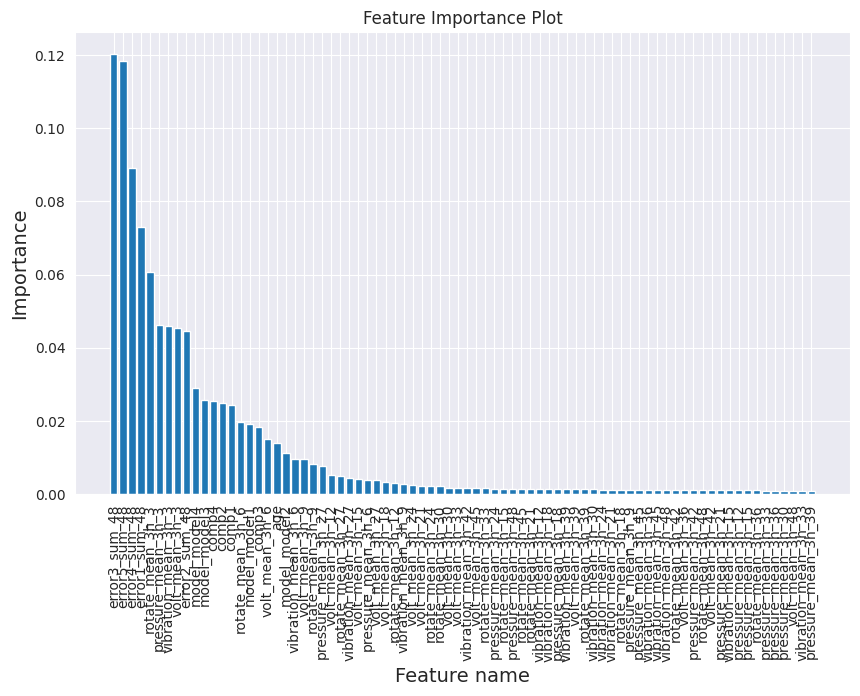

In [118]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

In [119]:
# Append rows from list of tables to combined table 
'''table_comb = PrettyTable()
table_comb.field_names = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
tlist = [table24_3hr,table24_shift_3hr,table48_3hr,table48_shift_3hr,table48_6hr]
for t in tlist:
    for row in t.rows:
        table_comb.add_row(row)'''
        
#table_comb.sortby = "Mean" # Score"
#table_comb.reversesort = True
'''
table_comb.field_names = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
tlist = [table24_3hr,table24_shift_3hr,table48_3hr,table48_shift_3hr,table48_6hr]'''

# create a DataFrame
table_comb = pd.DataFrame(columns=["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"])

# create a list of DataFrames
tlist = [table24_3hr, table24_shift_3hr, table48_3hr, table48_shift_3hr, table48_6hr]

# concatenate DataFrames vertically
table_comb = pd.concat([table_comb] + tlist, ignore_index=True).sort_values(["Pred/lag hour", "Rank"])
#table_comb.sort_values(["Pred", "Rank"])
# print the resulting DataFrame
# print(table_comb)

In [120]:
# Dictionary of DFs with model variable name and model description
dfs = {'model24_3hr':"24hr Predition 3hr", 'model48_3hr':"48hr Predition 3hr",
       'model48_6hr':"48hr Predition 6hr", 'model24_shift_3hr':"24hr Predition 3hr Shift"
       ,'model48_shift_3hr':"48hr Predition 3hr Shift"}

# Create recall DF
recall_df = pd.DataFrame(columns=['comp1', 'comp2', 'comp3', 'comp4', 'none']) 
for df_name, df_descrip in dfs.items():
    # Access the dataframe using the globals() function
    df = pd.DataFrame(globals()[df_name])
    df['Recall'] = df['Recall'].round(4)
    df.reset_index(drop=True, inplace=True)
    df_transpose = df.transpose()  # Transpose DF
    df_transpose = df_transpose.iloc[1:] # Remove 1st row 
    df_transpose.index = [df_descrip] # Rename 'Value' to Model description
    # Rename DF columns
    df_transpose.columns = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
    # Append the DF to combined recall DF
    recall_df = pd.concat([recall_df, df_transpose], ignore_index=False, axis=0)
    
table = PrettyTable()
table.field_names = ['Prediction / Recall Scores'] + list(recall_df.columns)

# Add rows to the table
for row in recall_df.itertuples():
    table.add_row([row[0]] + list(row[1:]))
    
table.sortby = "Prediction / Recall Scores"

print("The table below shows the prediction and lag hours, the Classifier, the Rank of the Classifier for the prediction and lag hours, sorted by the Mean Score and the best HyperParameter. \nFor 48hr prediction with 3hr and 6hr lag, only XGBClassifier was used.")
#print(table_comb)
display(table_comb)
print()
print()
# Print the table
print("The best performing Models for each prediction were captured with XgBoost, using various hyper parameters tuning. \nSee table above.(Rank 1 for Pred/lag hour)")
#print(table)
display(table)

The table below shows the prediction and lag hours, the Classifier, the Rank of the Classifier for the prediction and lag hours, sorted by the Mean Score and the best HyperParameter. 
For 48hr prediction with 3hr and 6hr lag, only XGBClassifier was used.


,Pred/lag hour,Classifier,Rank,Mean,Parameters
2,24hr 3hr,XGBClassifier,1,0.9986,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
0,24hr 3hr,RandomForestClassifier,13,0.9983,"{'clfr__max_depth': 20, 'clfr__n_estimators': 50}"
1,24hr 3hr,Pipeline,17,0.9966,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 10, 'clfr__lsvc__loss': 'squared_hinge'}"
3,24hr 3hr,HistGradientBoostingClassifier,35,0.9907,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 100}"
6,24hr 3hr Shift,XGBClassifier,1,0.9988,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
4,24hr 3hr Shift,RandomForestClassifier,13,0.9984,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
5,24hr 3hr Shift,Pipeline,17,0.9966,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 1, 'clfr__lsvc__loss': 'squared_hinge'}"
7,24hr 3hr Shift,HistGradientBoostingClassifier,35,0.9914,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 500}"
8,48hr 3hr,XGBClassifier,1,0.9876,"{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1}"
11,48hr 3hr Shift,XGBClassifier,1,0.9903,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 6, 'clfr__n_estimators': 1000}"




The best performing Models for each prediction were captured with XgBoost, using various hyper parameters tuning. 
See table above.(Rank 1 for Pred/lag hour)


Prediction / Recall Scores,comp1,comp2,comp3,comp4,none
24hr Predition 3hr,0.9359,0.9182,0.9911,0.925,0.9995
24hr Predition 3hr Shift,0.9295,0.9432,1.0,0.8821,0.9994
48hr Predition 3hr,0.6923,0.7102,0.9479,0.8839,0.9956
48hr Predition 3hr Shift,0.7804,0.7955,0.9762,0.8589,0.9958
48hr Predition 6hr,0.75,0.8091,0.9702,0.8786,0.9968


<a class="anchor" id="Observation"></a>
### General Observation 

On all models error count was the most important feature.
The predictions using the shift column lag had a slightly better score than the 3hr lag with mean, min, max and std.
XGboost was the best performing estimator, even without any hyper parameter tuning.  
When XGBClassifier was run without correcting duplicate errors the 24 hour model recall was over 97% for each component.
The longer the prediction window, the more difficult it is for the model to give accurate results.
In all models, comp3 had the best recall, but it could be related to the lowest count in the failure dataset. 
A lot more work will be needed on the 48 hour predicton model for it to be a good model for prediction of component failure.
In Machine Learning, EDA can take up a lot of time to prepare data for modelling.

### Observation on XGboost performance based on the number of days data inserted before the duplicate records

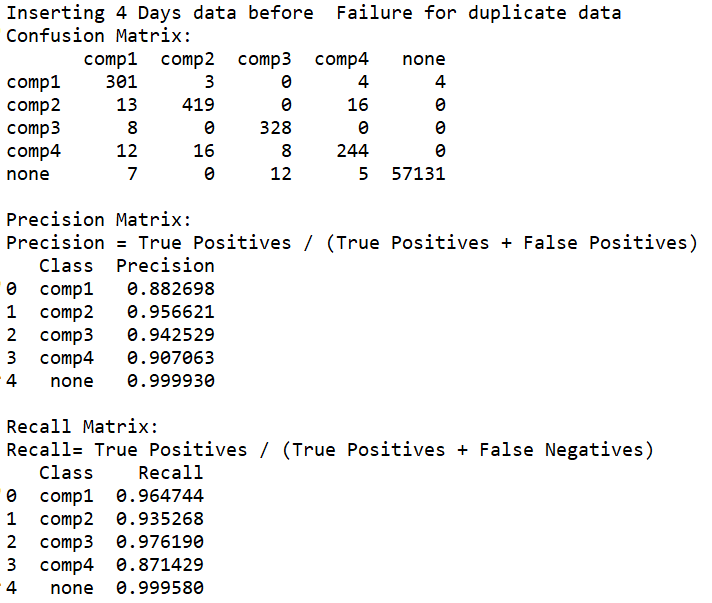

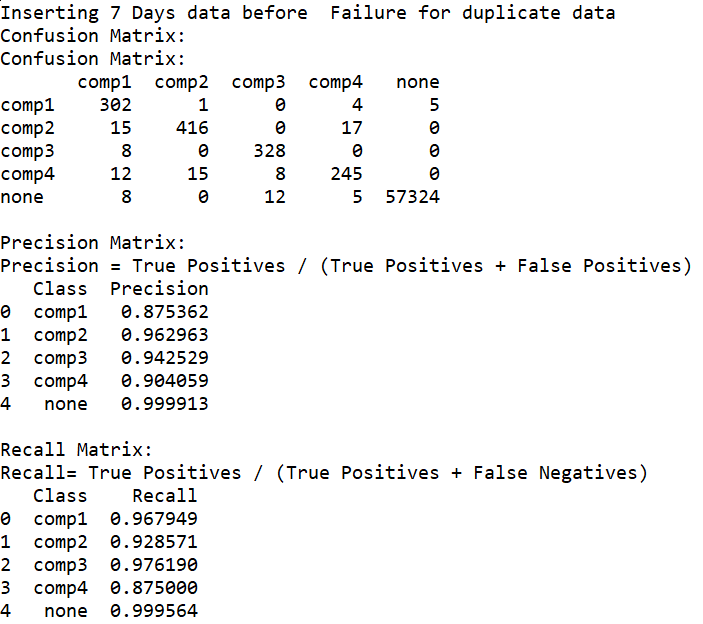

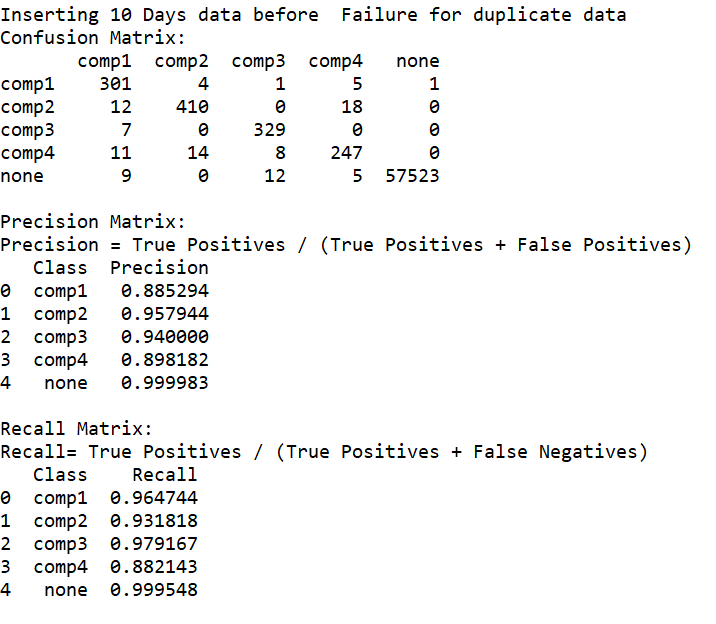

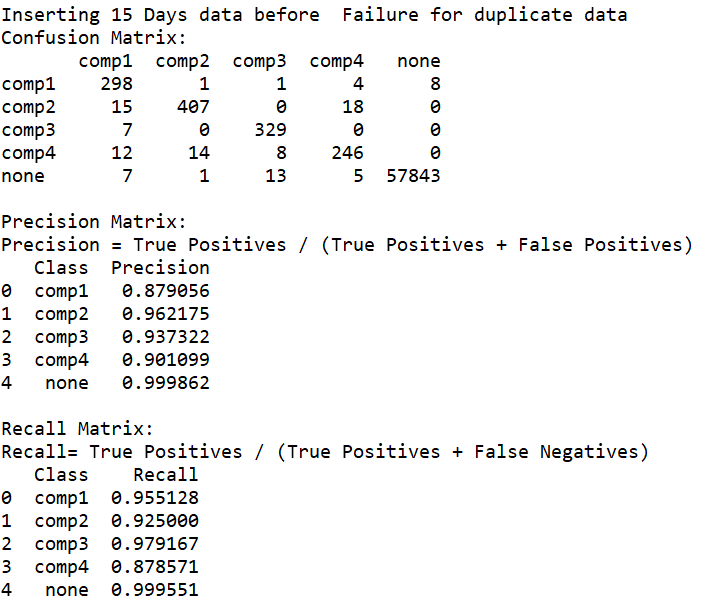